<h1> Magnet Emualtion using RBM </h1>

The goal of this project is to provide a fast emulation of the array of magnets at SECAR. 

To achieve this emulation we use the following procedure:<br>
    
1. Generate multiple transport matrices for a single magnet using Cosy, varying current only (for now).<br>
2. Perform a PCA analysis of the resulting data.<br>
3. Build an emulator which takes currents and returns matrix elements.<br>
4. We are also exploring some new avenues to encode more than one imput efficiently.<br>

<h2> Code structure </h2>

The structure of the code is as follows:

1. CosyIO: Handles the reading and writing of cosy files
2. Emulator: Performs PCA analysis at build time, and uses cubic splines at runtime to interpolate the parameter-space eigenfunctions. Section 4 is an exploration of a non-interpolating method to emulate cosy. 
3. NonRedundant(Emulator): Subclass of emulators that only emulates non-constant matrix elements.
4. CosyMagnet(Emulator): Interface class used to comunicate cosy data in and out of the Emulator.
5. SECAR: Handles ray emulation for arrays of CosyMagnets.
6. SECARMagnet,StaticSECARMagnet: Interface between SECAR and CosyMagnet.

In [1]:
import time, os, shutil, subprocess
import math, array, random

import cosyHelp as cosy

from CosyIO import CosyIO
from Emulator import Emulator
from NonRedundant import NonRedundant

from CosyMagnet import CosyMagnet

from SECARMagnet import SECARMagnet
from StaticSECARMagnet import StaticSECARMagnet
from SECAR import SECAR

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy as sp
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
from scipy.special import rel_entr

<h2>1. cosyIO handles cosy input/output operations </h2>

Here we open a cosy  and extract its contents into python.

(The Emulator assumes the data is a matrix where every row correponds to the flattened cosy matrix for some current.)

In [2]:
path = "MagnetData/Magnet_1_v2"
dir_list = os.listdir(path)
scales = [ float(name) for name in dir_list ]

''' Load all the files in the directory '''
big_matrix = []
cosyIO = CosyIO()
for i in range(len(dir_list)):
    ''' Read all the matrices '''
    cosyIO.read(os.path.join(path,dir_list[i]))
    ''' Flatten the matrix and store it '''
    big_row = []
    for mat in cosyIO.matrices:
        for row in mat:
            big_row.append(row)
    big_matrix.append(big_row)
big_matrix = np.array(big_matrix)

<h4> For example the flattened cosy matrix for scale = 0.94 looks like </h4>

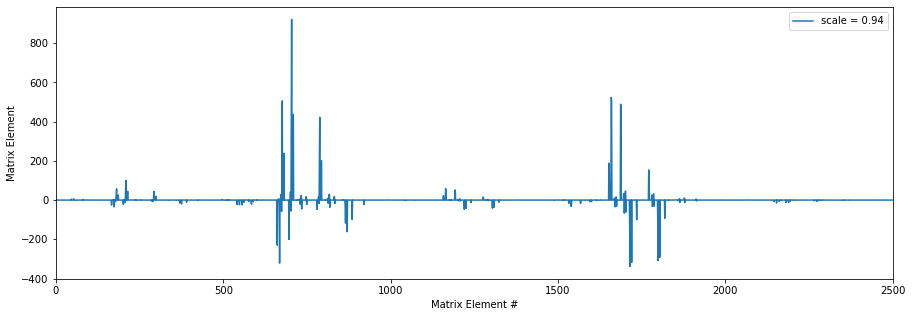

In [3]:
index = 44

plt.rcParams['figure.figsize'] = [15, 5]

plt.plot(big_matrix[index],label="scale = "+str(dir_list[index]))
plt.xlabel("Matrix Element #")
plt.ylabel("Matrix Element")
plt.xlim((-1,2500))
plt.legend()
plt.show()

<h2> 2. and 3. Single magnet emulator: performs the PCA analysis and interpolates at runtime. </h2>

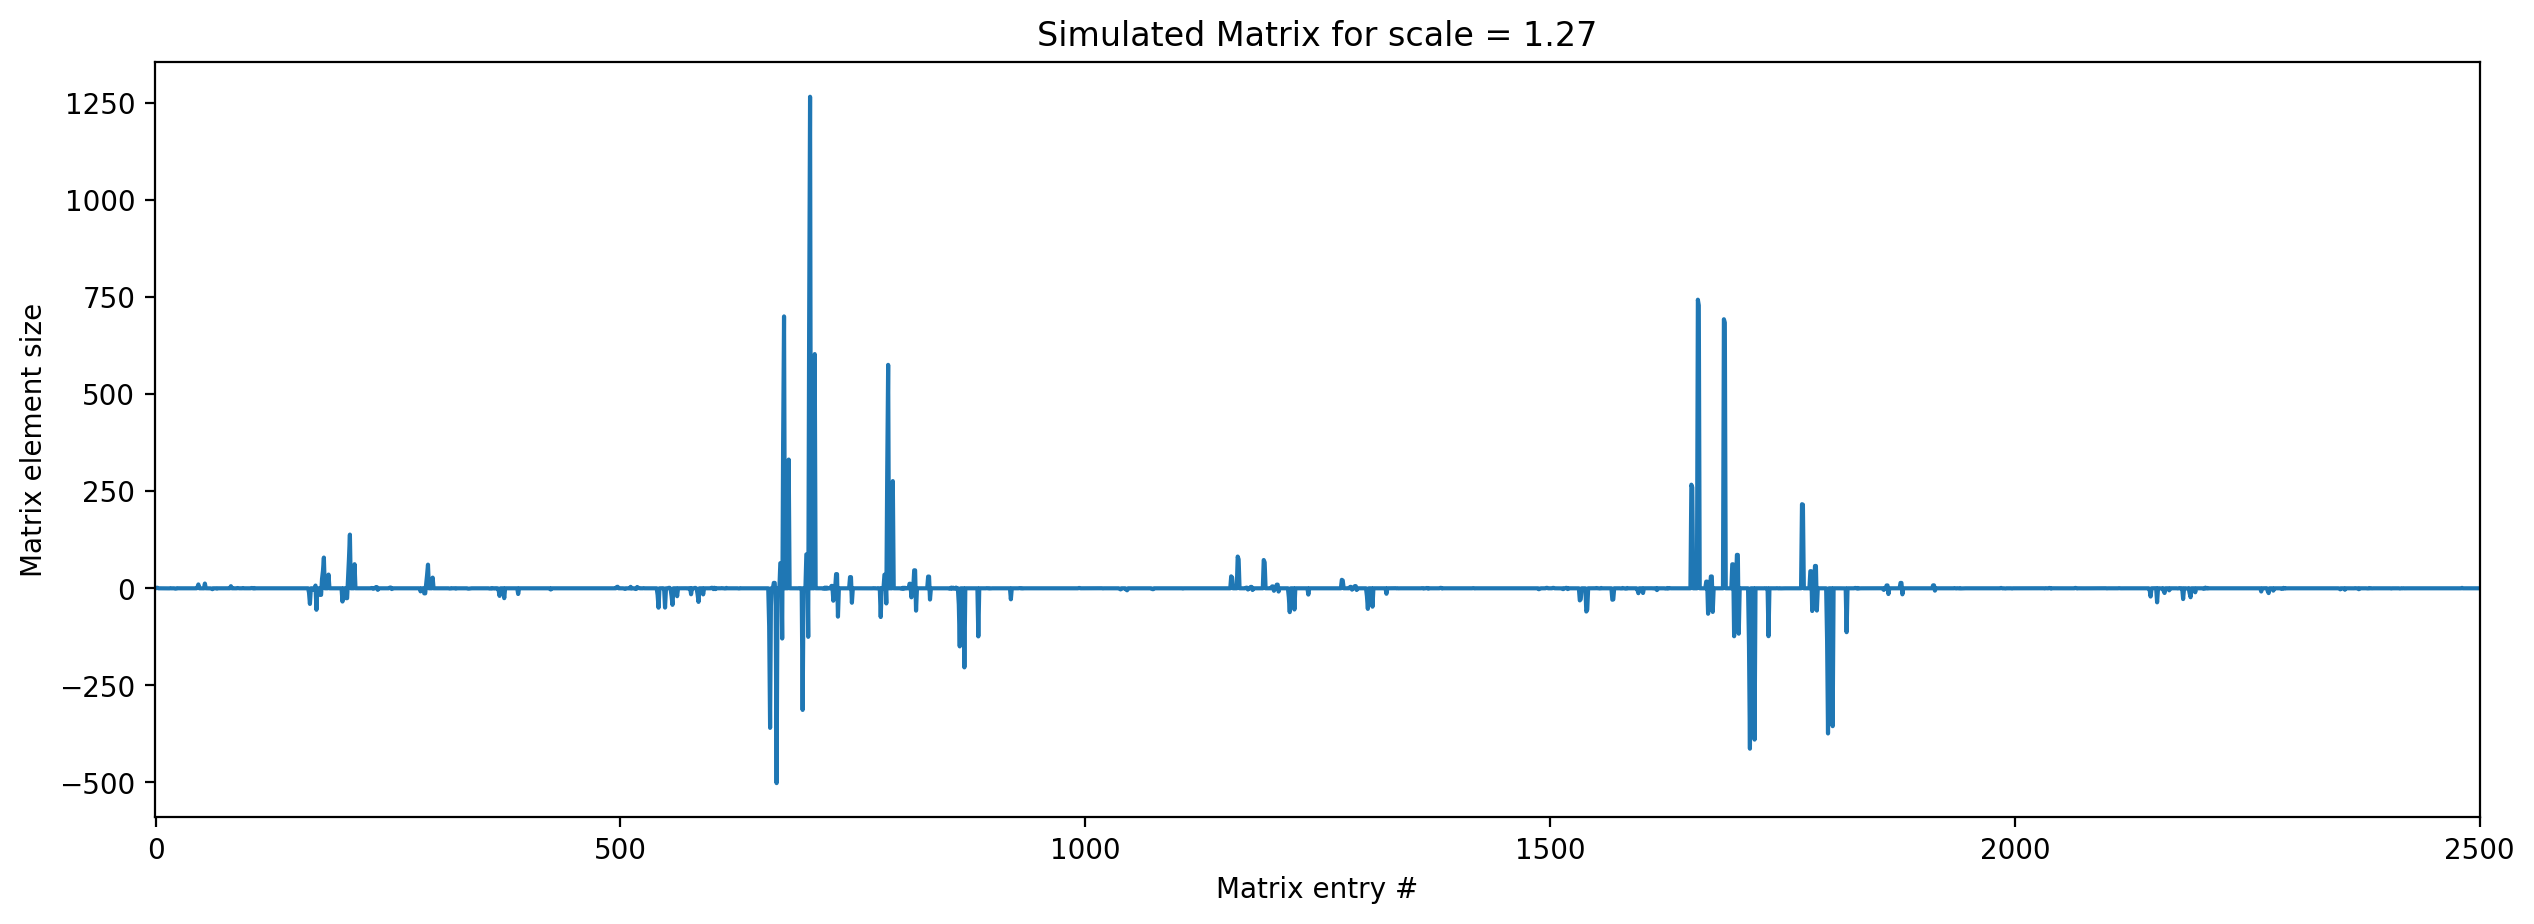

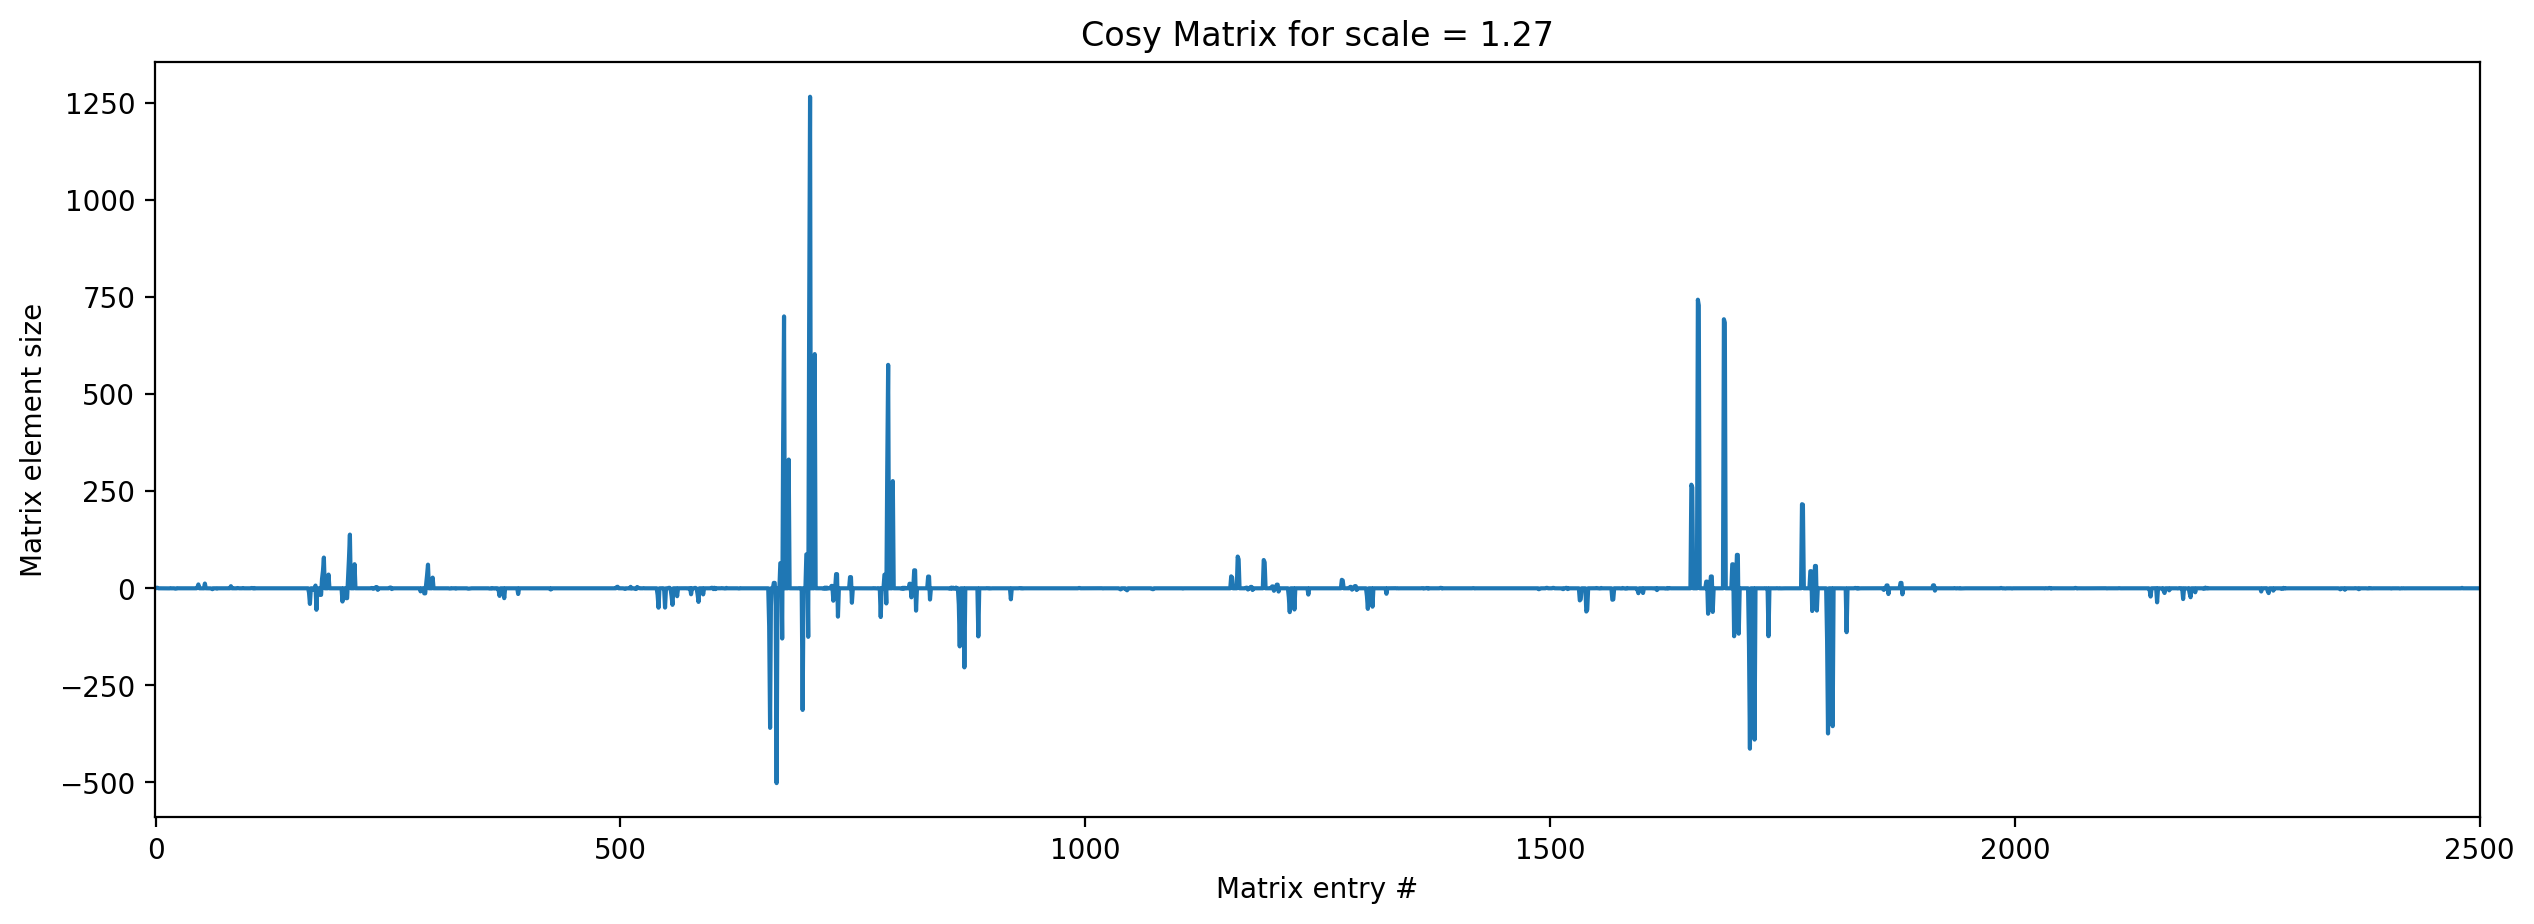

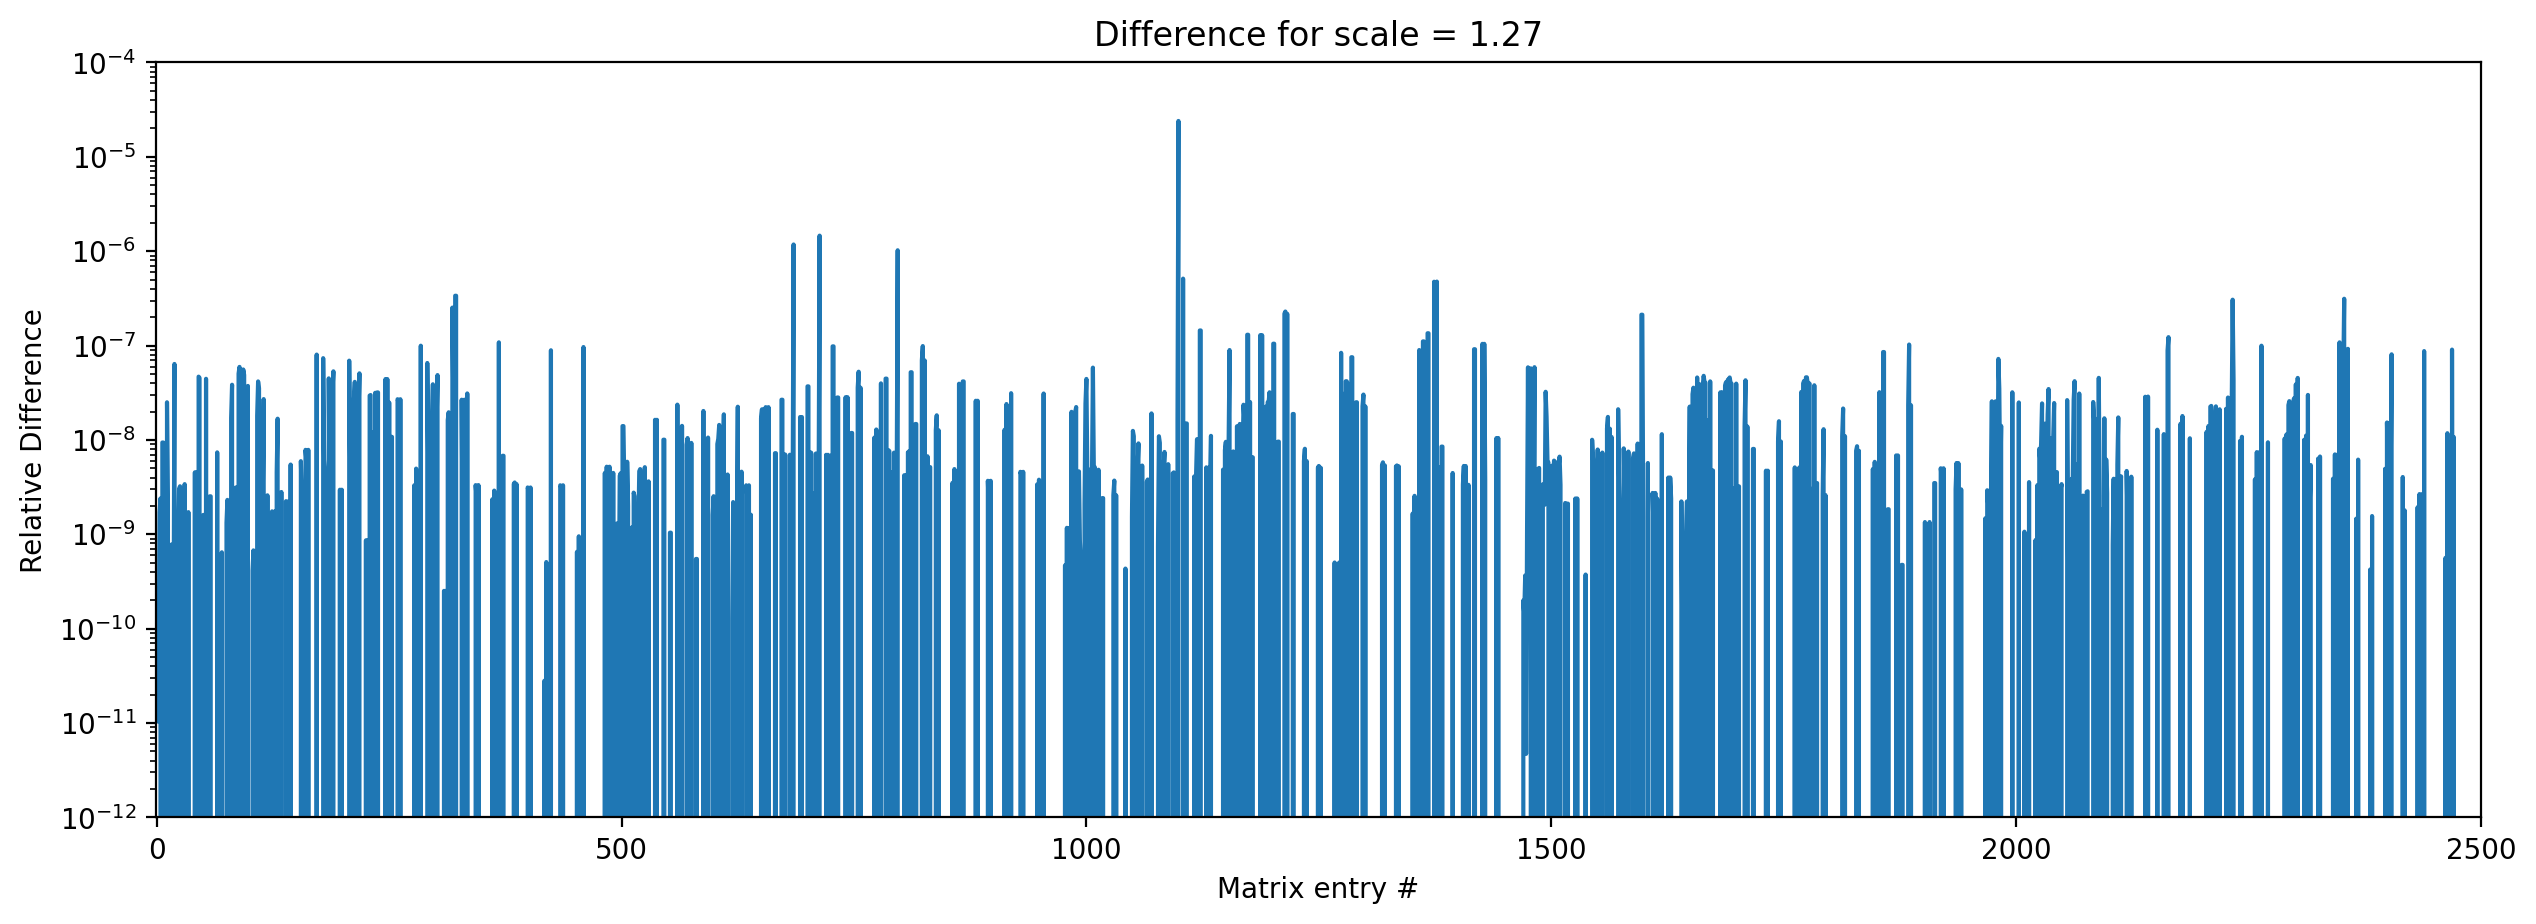

In [24]:
''' Test one emulator instance '''
from math import *
def error(emulated,real):
    return np.sqrt(np.sum(np.square(emulated - real))/np.sum(np.square(real)))

numpc = 15
index = 77

''' Emulator using the first numpc principal components '''
MagnetEmulator = Emulator(scales,big_matrix,numpc)



''' Plotting the emulated magnet '''
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
ax.plot(MagnetEmulator(scales[index]))
plt.title("Simulated Matrix for scale = "+str(dir_list[index]))
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.xlim((-1,2500))
plt.show()

''' Plotting the cosy loaded data '''
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
ax.plot(big_matrix[index])
plt.title("Cosy Matrix for scale = "+str(dir_list[index]))
plt.xlabel("Matrix entry #")
plt.ylabel("Matrix element size")
plt.xlim((-1,2500))
plt.show()


emulated = MagnetEmulator(scales[index])
real     = big_matrix[index]
relative = [ abs(real[i]-emulated[i]) / ( real[i] if real[i]!=0 else (emulated[i] if emulated[i]!=0 else 1) ) for i in range(len(real)) ]

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
ax.semilogy(relative)
plt.ylim(1E-12,1E-4)
plt.title("Difference for scale = "+str(dir_list[index]))
plt.xlabel("Matrix entry #")
plt.ylabel("Relative Difference")
plt.xlim((-1,2500))
plt.show()

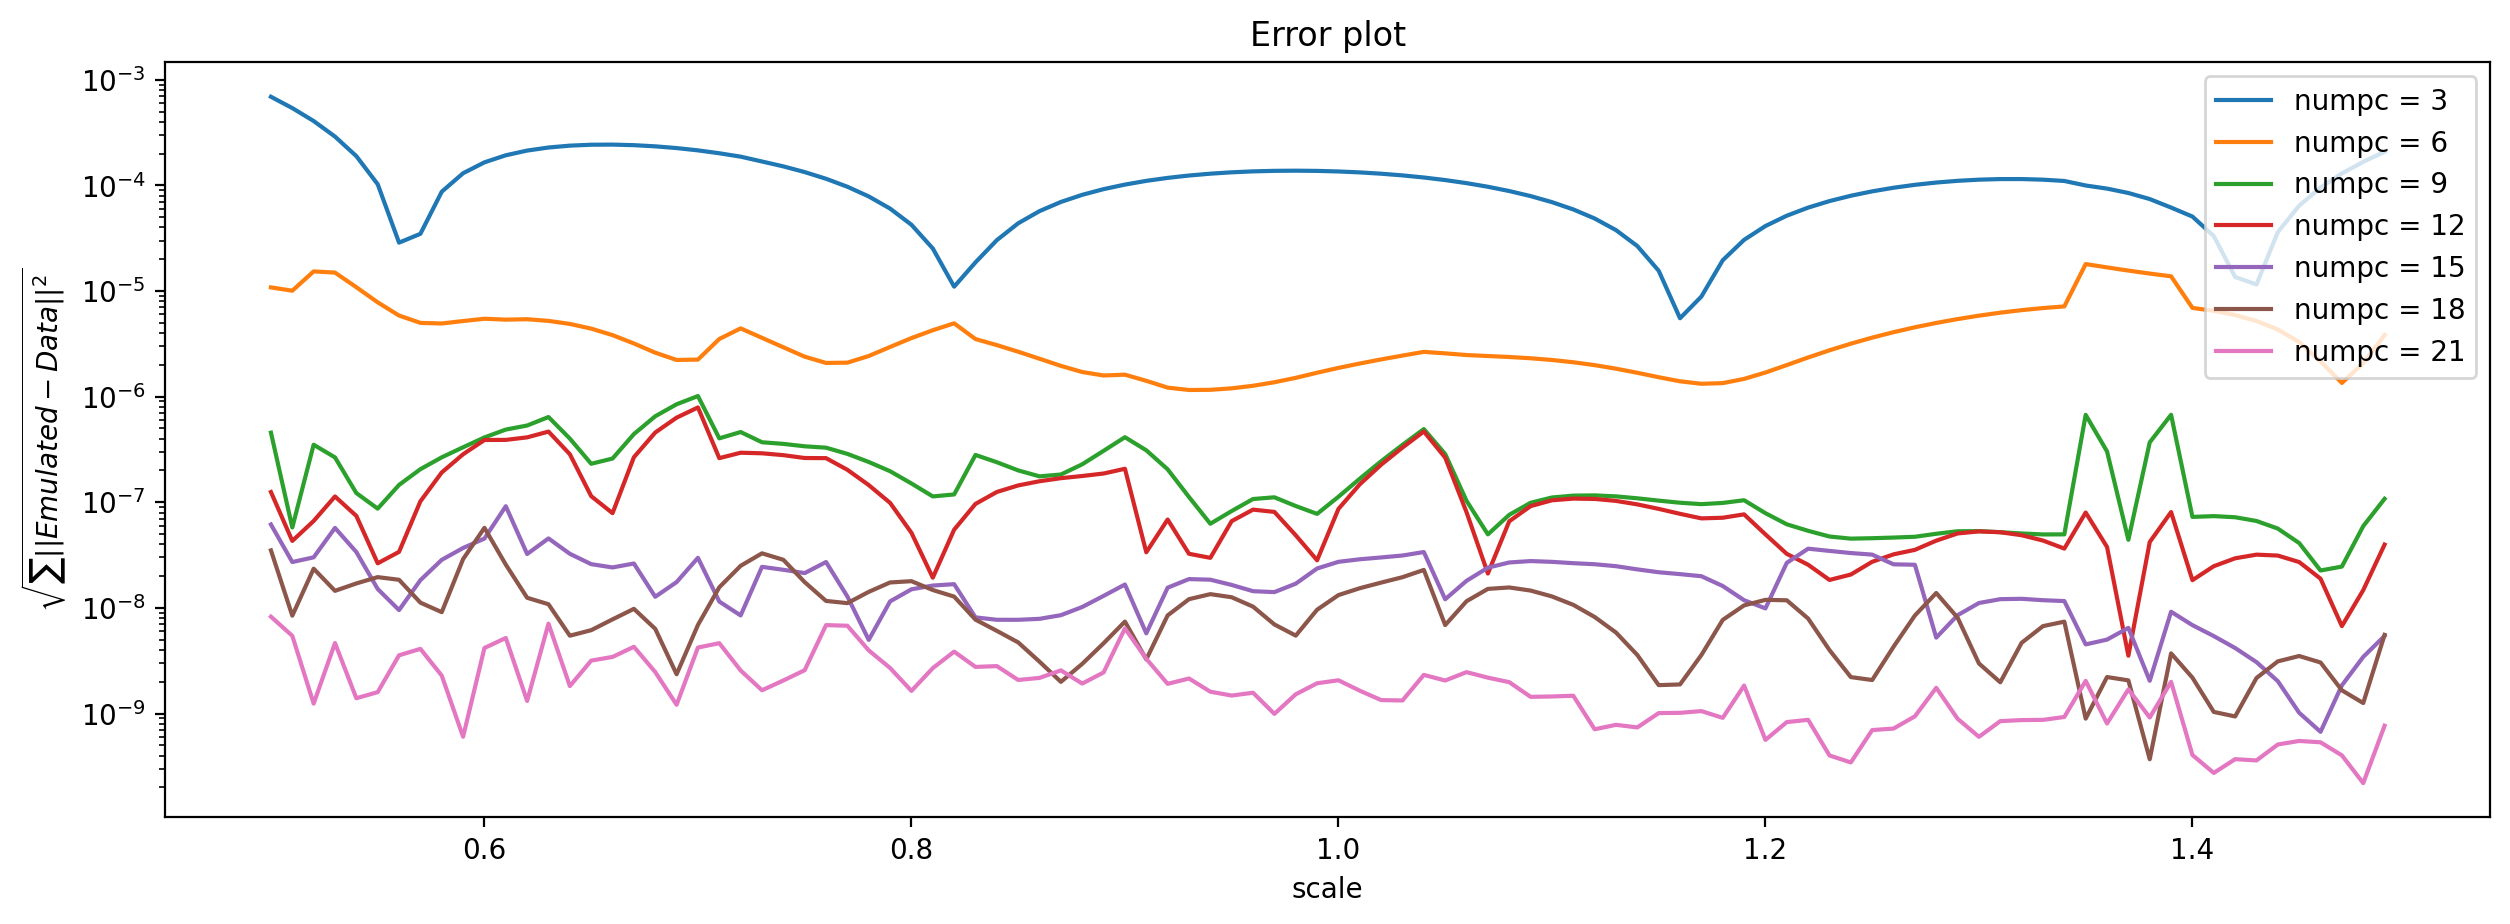

In [25]:
''' Tests several instances '''
nEmulators = 7
Emulators  = [ Emulator(scales,big_matrix,3*i+3) for i in range(nEmulators) ]
error_matrix = [ [ error(Emulators[i](scales[j]),big_matrix[j]) for j in range(len(scales)) ] for i in range(nEmulators) ]

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
for i in range(nEmulators):
    ax.semilogy(scales,error_matrix[i],label="numpc = "+str(3*i+3))
plt.xlabel("scale")
plt.ylabel(r'$\sqrt{\sum ||Emulated - Data||^2}$')
plt.title("Error plot")
plt.legend()
plt.show()

In [6]:
''' Timing checkup '''
path_magnet1 = "MagnetData/Magnet_1_train"
magnet1 = CosyMagnet(path=path_magnet1,cutoff=3)

minimum = min(magnet1.axis)
maximum = max(magnet1.axis)

nevals = 10000

start = time.time()
for i in range(nevals):
    scale = minimum + random.random()*(maximum-minimum)
    magnet1(scale)
print(str(nevals),"evaluations took",time.time()-start,"seconds")

10000 evaluations took 12.358675241470337 seconds


In [7]:
%%timeit
magnet1(0.5)

1.24 ms ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<h4> We can look at the data inside the emulator class </h4>

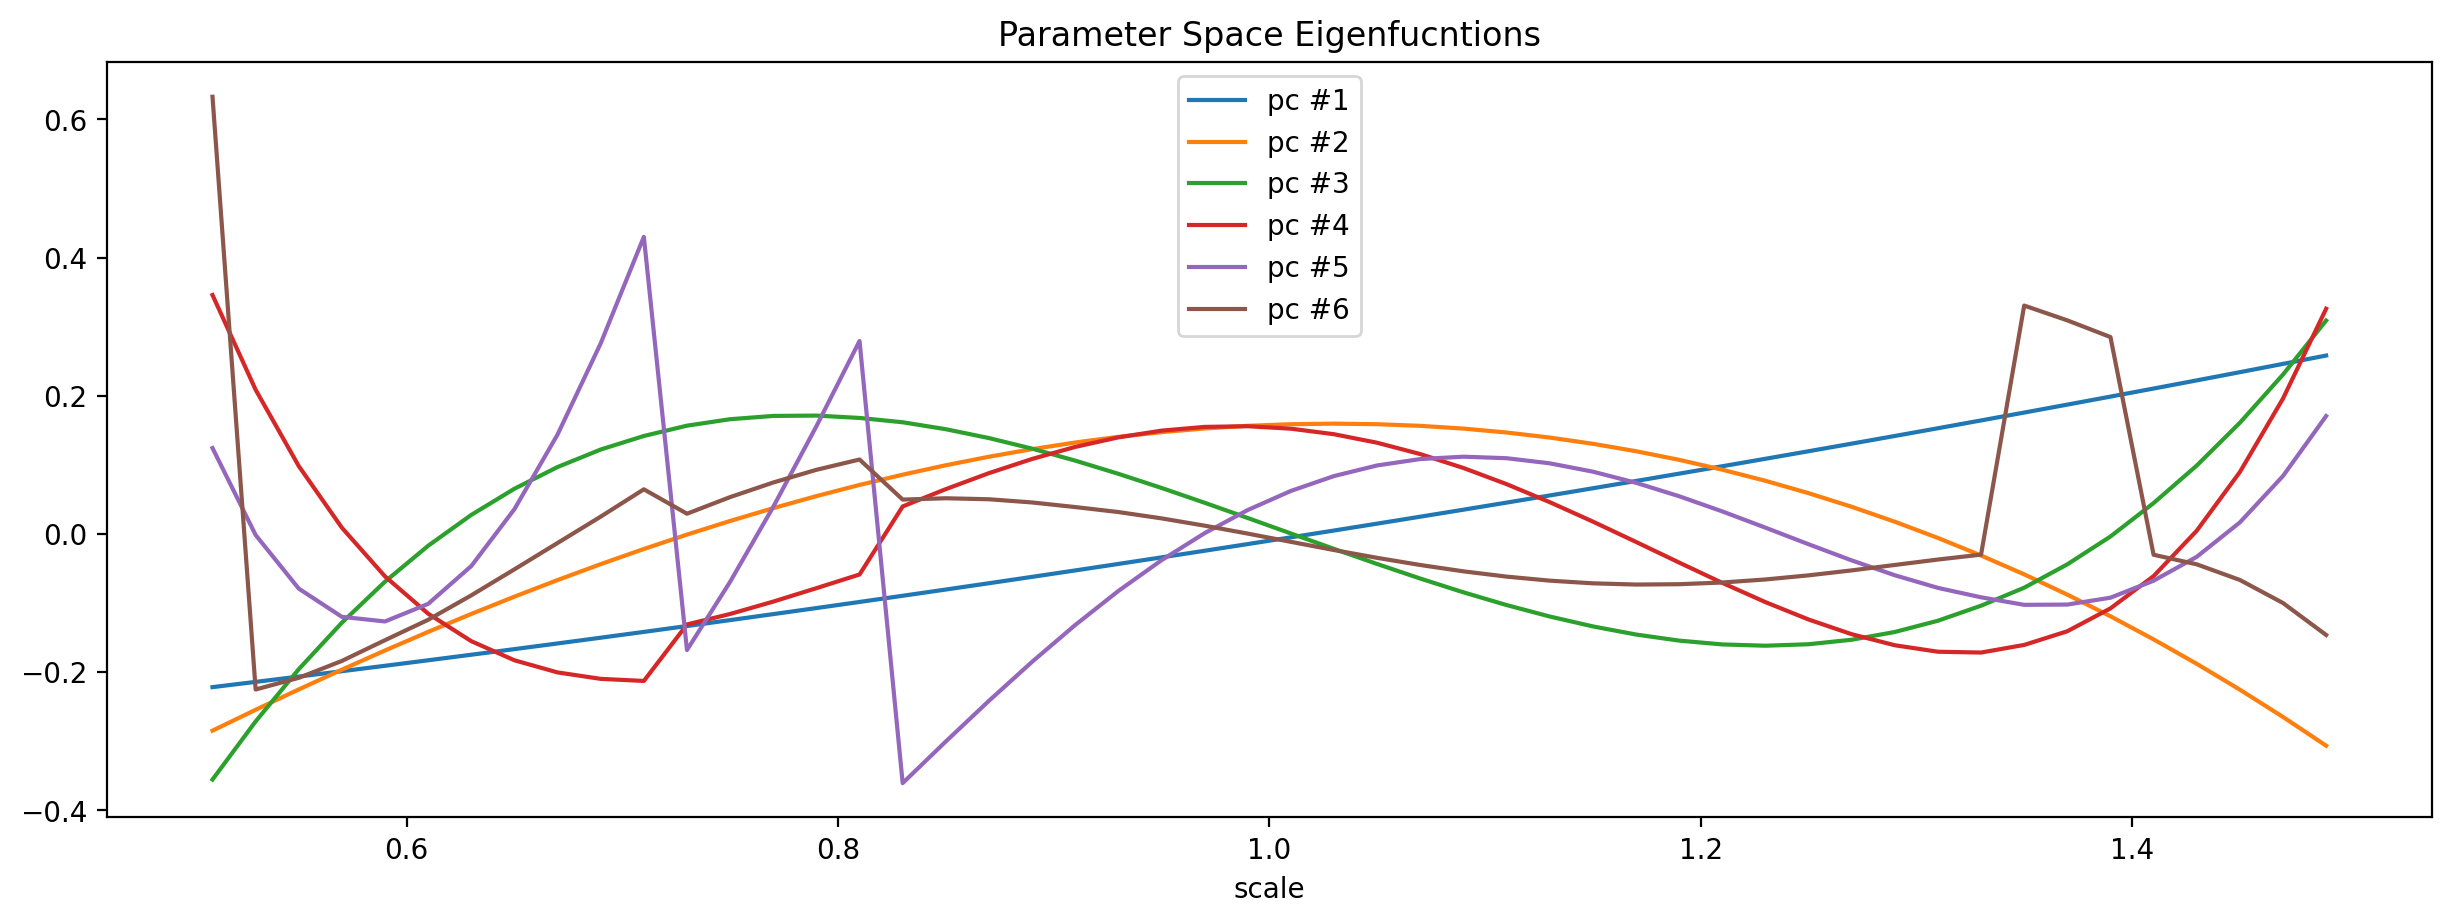

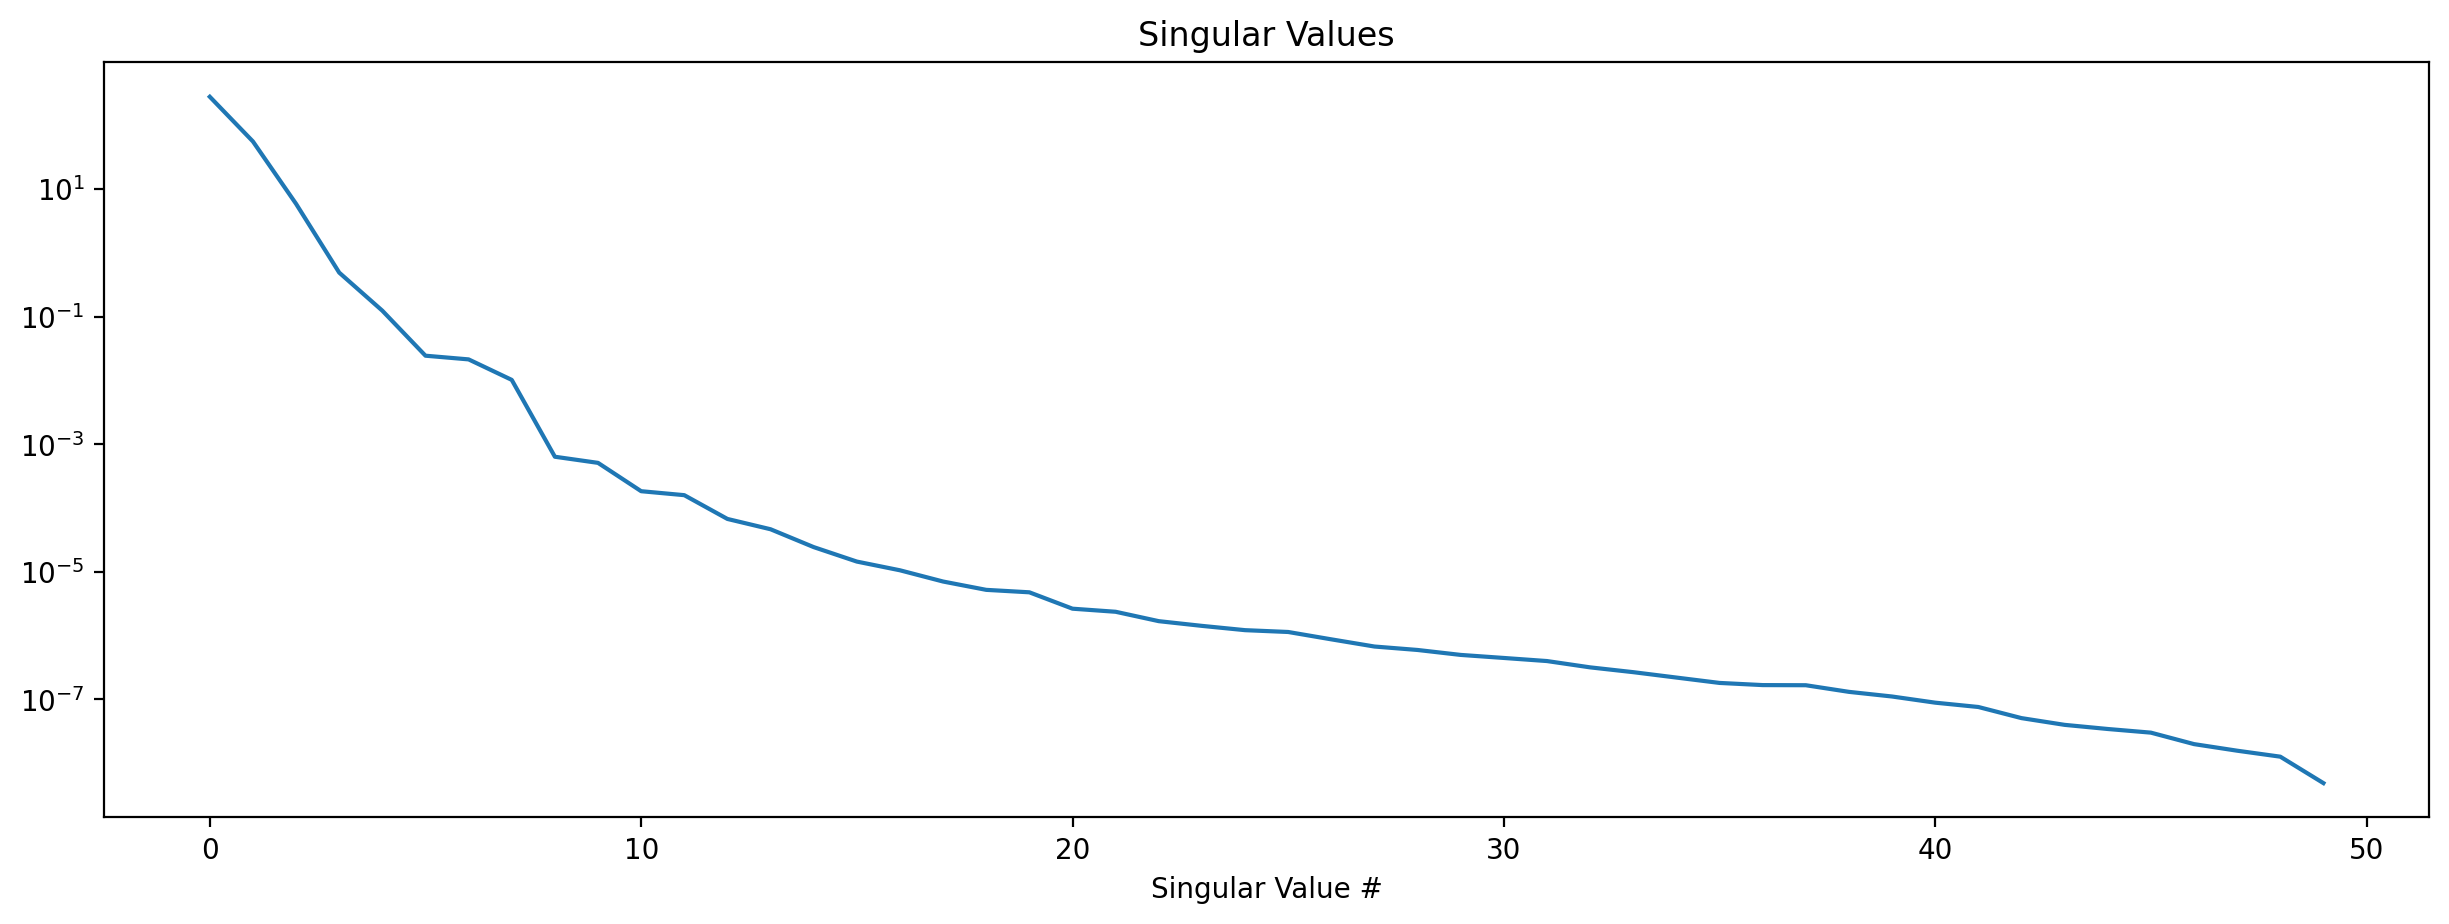

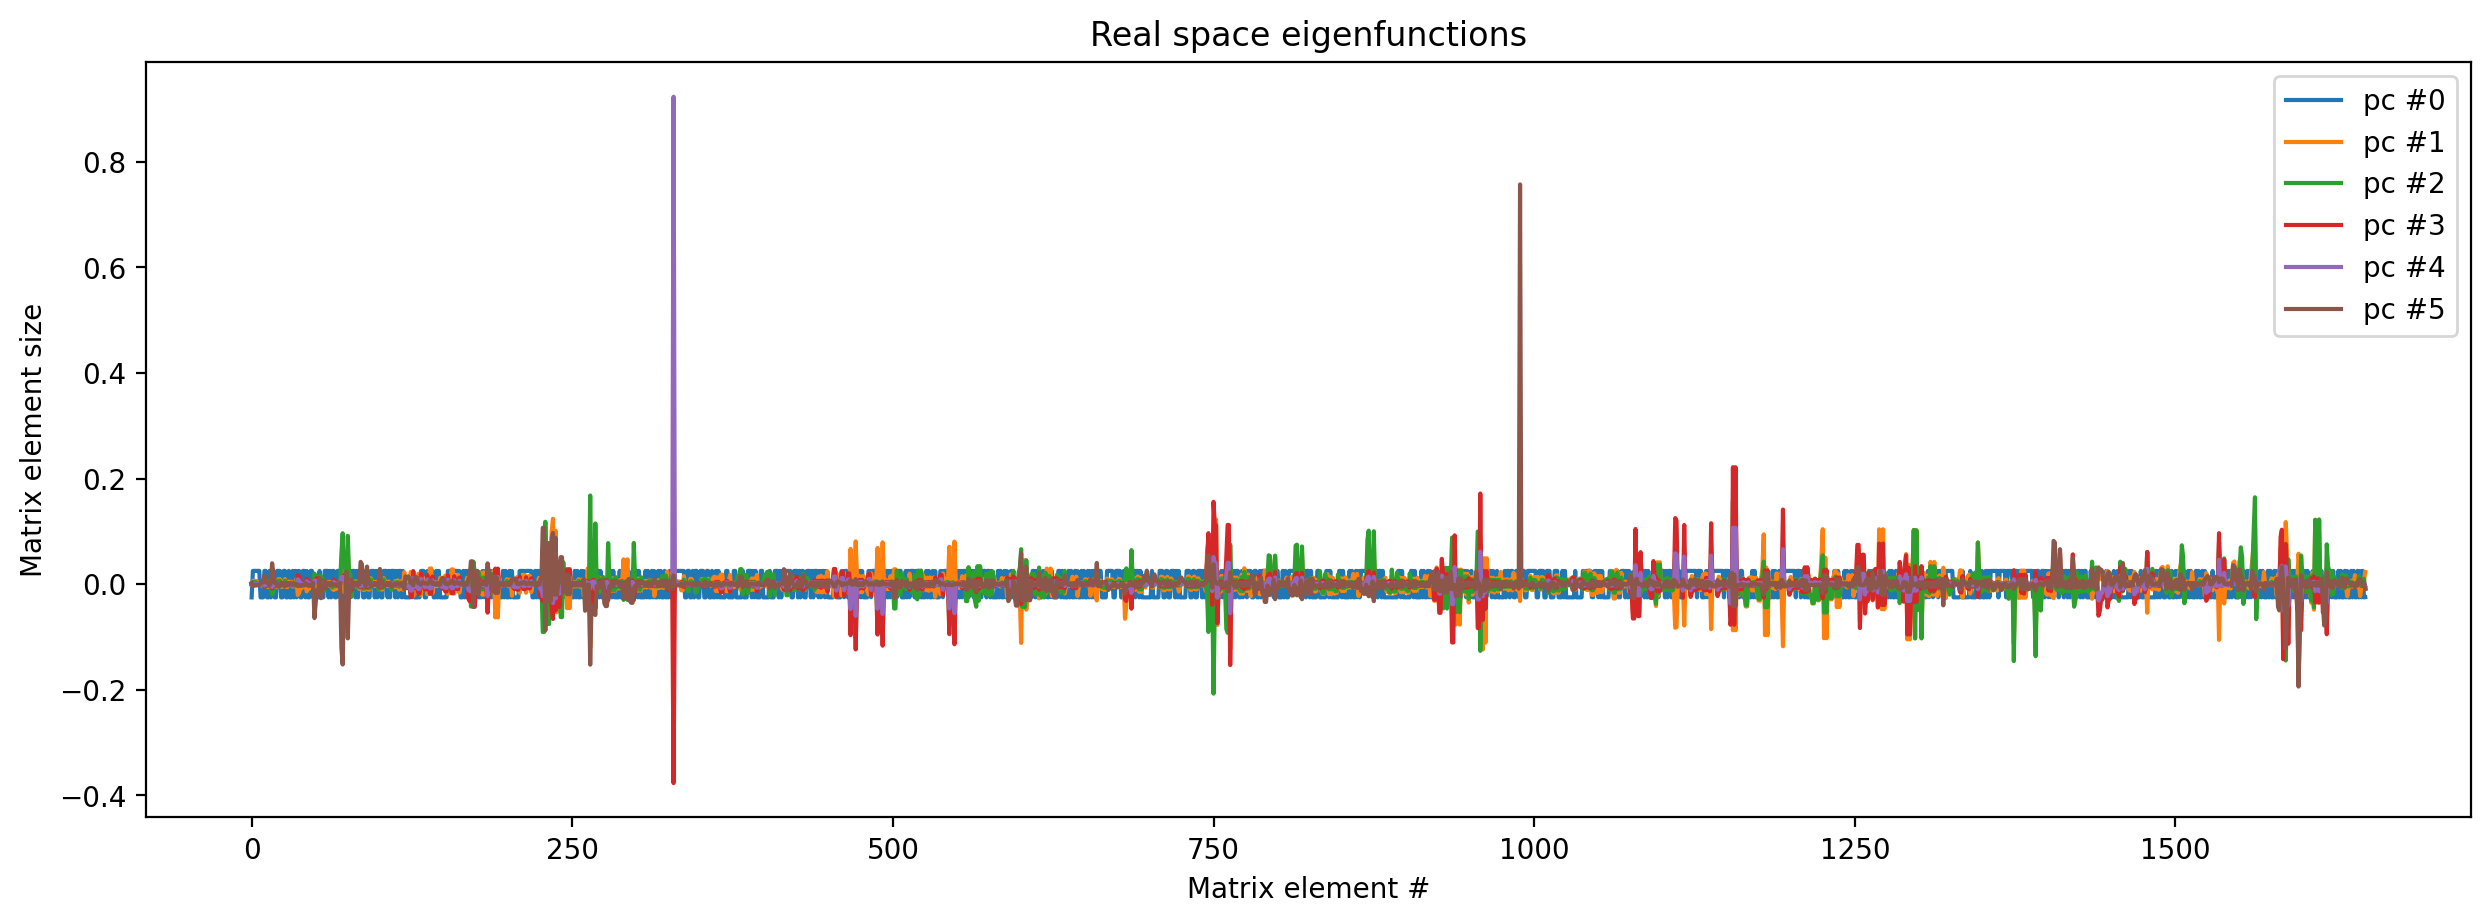

In [28]:
''' Parameter Space Eigenfunctions '''
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
for i in range(6):
    ax.plot(magnet1.axis,magnet1.u[:,i],label="pc #"+str(i+1))
plt.legend()
plt.title("Parameter Space Eigenfucntions")
plt.xlabel("scale")
plt.show()

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
ax.semilogy(magnet1.s)
plt.title("Singular Values")
plt.xlabel("Singular Value #")
plt.show()


fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
for i in range(6):
    ax.plot(magnet1.v[i],label="pc #"+str(i))
plt.legend()
plt.title("Real space eigenfunctions")
plt.xlabel("Matrix element #")
plt.ylabel("Matrix element size")
plt.show()

<h4> We can also write to file the emulated matrix elements directly from the emulator </h4>

In [9]:
''' Sample use of the parser '''
scale = 0.5626
magnet1.write(scale,os.path.join("Generated_Magnet_Data",str(scale)))

<h2> Simulating SECAR </h2>

In [10]:
def generateInitialDistribution(widthX, widthY, aX, aY, numberMC=1000):
    beam = np.zeros([numberMC, 8], dtype="float64", order="F")

    for j in range(numberMC):
        # Sampling within ellipse of possible positions
        r = widthX * np.sqrt(random.uniform(0, 1))
        theta = random.uniform(0, 1) * 2 * np.pi
        x = xh + r * np.cos(theta)
        y = yh + widthY/widthX *  r * np.sin(theta)
        beam[j][0] = x/1000 # in m
        beam[j][2] = y/1000 # in m

        # Sampling within ellipse of possible angles
        r = aX * np.sqrt(random.uniform(0, 1))
        theta = random.uniform(0, 1) * 2 * np.pi
        angleX = r * np.cos(theta)
        if aX != 0:
            angleY = aY/aX *  r * np.sin(theta)
        else:
            angleY = aY * np.sqrt(random.uniform(0, 1))
        beam[j][1] = angleX/1000 # in rad
        beam[j][3] = angleY/1000 # in rad
        beam[j][5] = dE
    return (beam)

<h4> Here we compare beam transport using cosy input and emulated input trained on half the cosy data </h4>

In [11]:
''' Dynamic Magents require several current files to build emulators '''
dynamic_magnets = [ 
                    SECARMagnet(path="MagnetData/Q1/train",cutoff=3),
                    SECARMagnet(path="MagnetData/Q2/train",cutoff=3),
                    StaticSECARMagnet(path="MagnetData/B1/full/1.00"),
                    StaticSECARMagnet(path="MagnetData/B2/full/1.00"),
                    SECARMagnet(path="MagnetData/S1/train",cutoff=3),
                    SECARMagnet(path="MagnetData/Q3/train",cutoff=3),
                    SECARMagnet(path="MagnetData/Q4/train",cutoff=3),
                    SECARMagnet(path="MagnetData/Q5/train",cutoff=3),
                  ]

''' SECAR instance using emulated magnets, dipoles which are lookup tables '''
dynamic_secar = SECAR(magnets=dynamic_magnets)

<h4> Cosy input is handled via static magnets, a.k.a. lookup tables </h4>

In [12]:
''' Static Magents require a single lookup magnet file '''
settings  = [ {'name':'Q1','current':'1.23'},
              {'name':'Q2','current':'1.13'},
              {'name':'B1','current':'1.00'},
              {'name':'B2','current':'1.00'},
              {'name':'S1','current':'1.31'},
              {'name':'Q3','current':'0.70'},
              {'name':'Q4','current':'0.87'},
              {'name':'Q5','current':'1.44'}
            ]

''' Static magnet array '''
static_magnets = [ StaticSECARMagnet(path=os.path.join("MagnetData",s['name'],"full",str(s['current']))) for s in settings ]

''' SECAR instance using lookup tables '''
static_secar = SECAR(magnets=static_magnets)

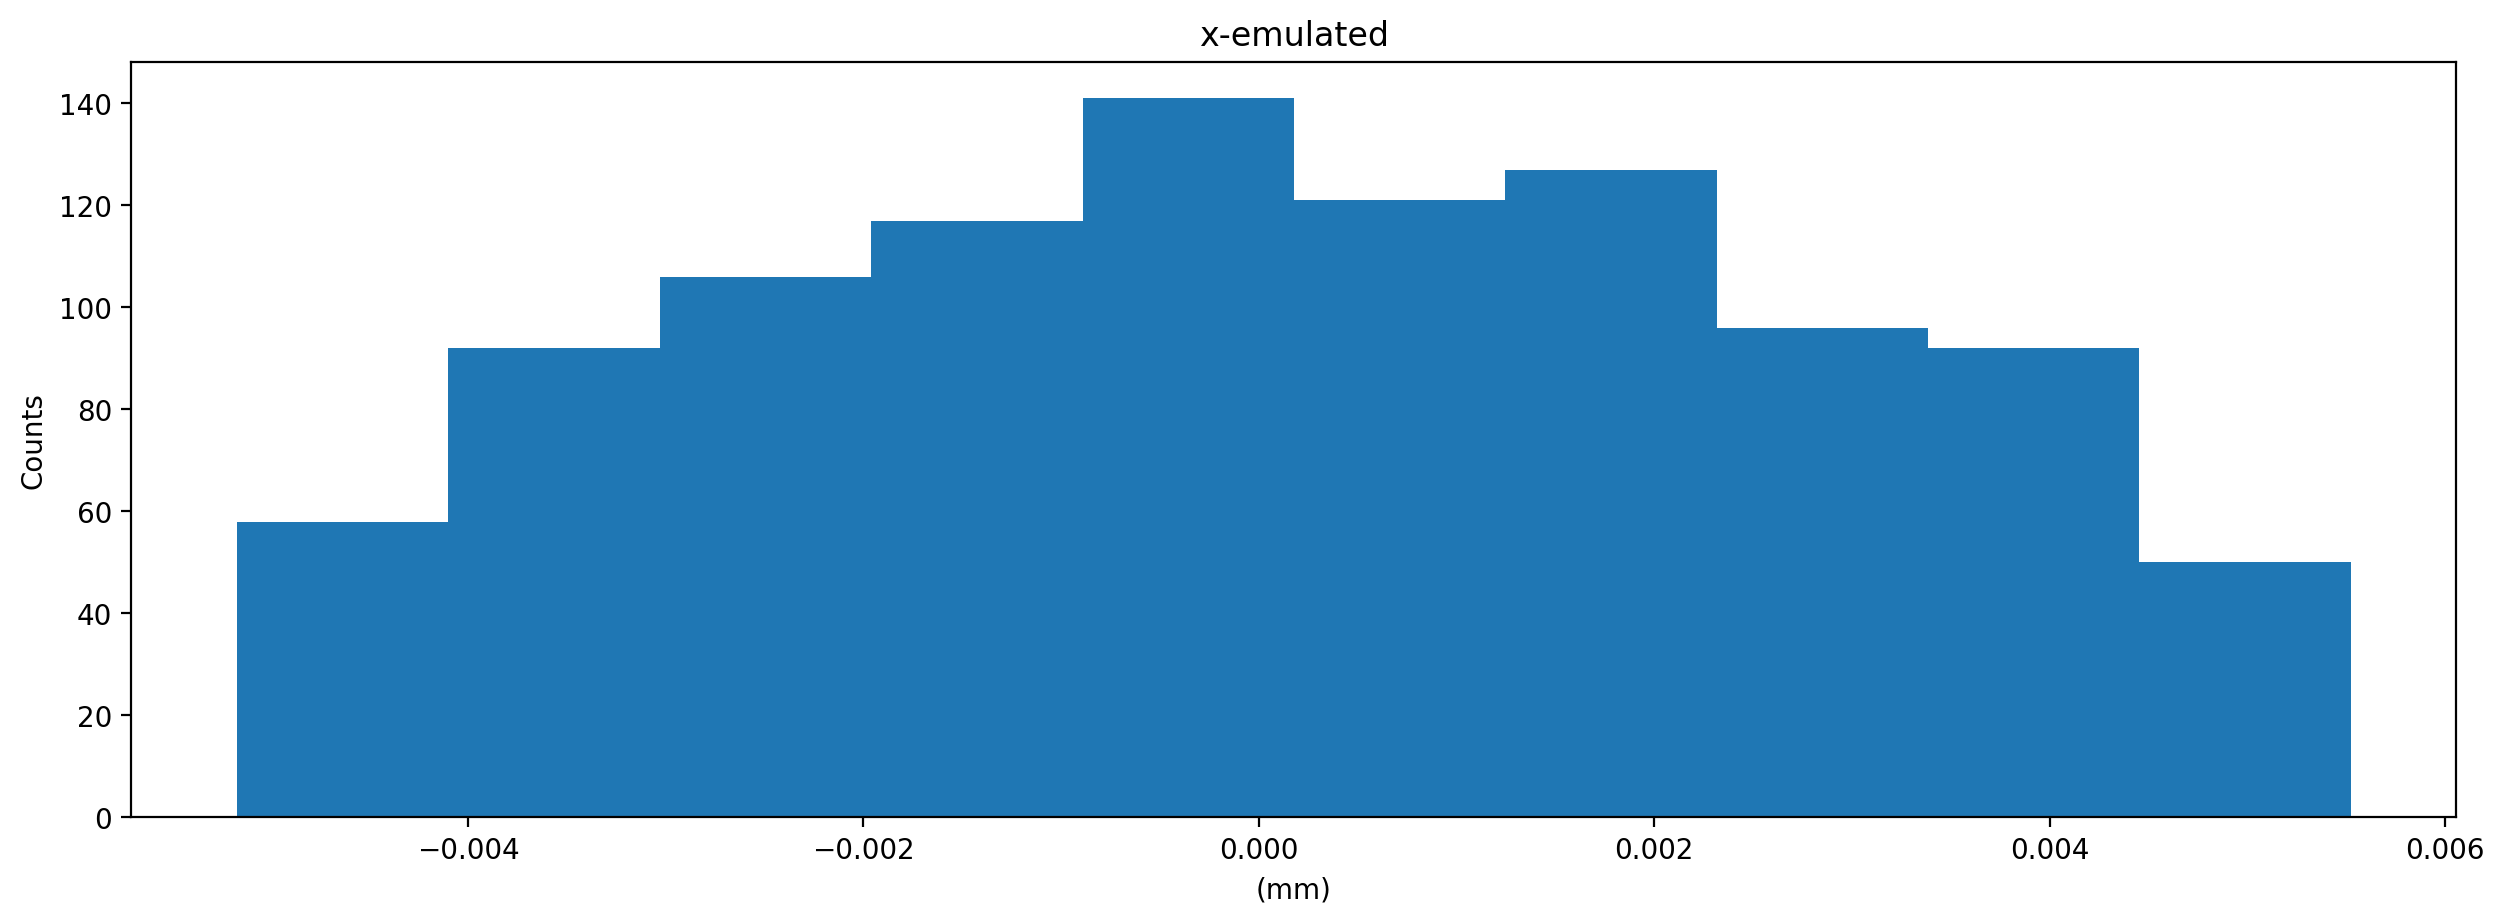

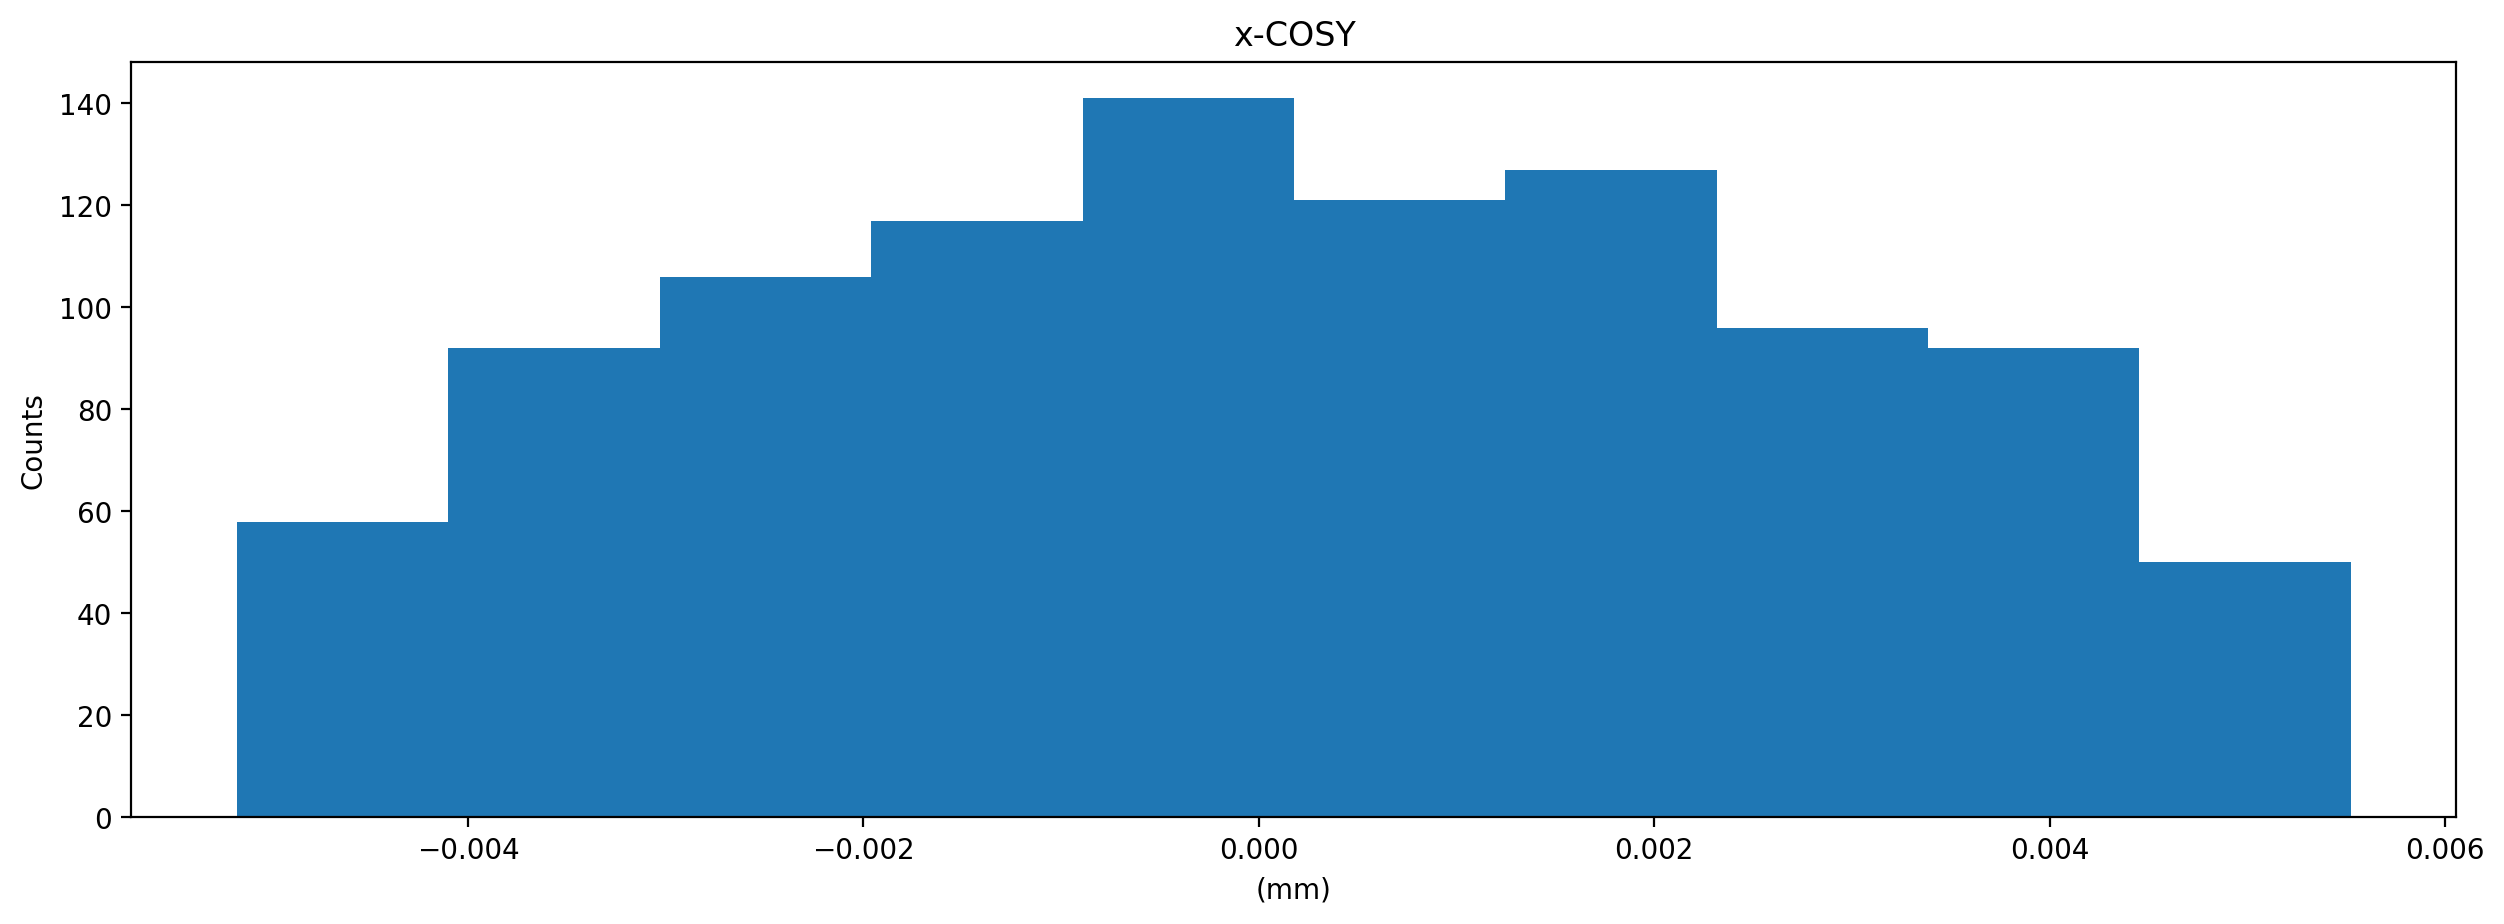

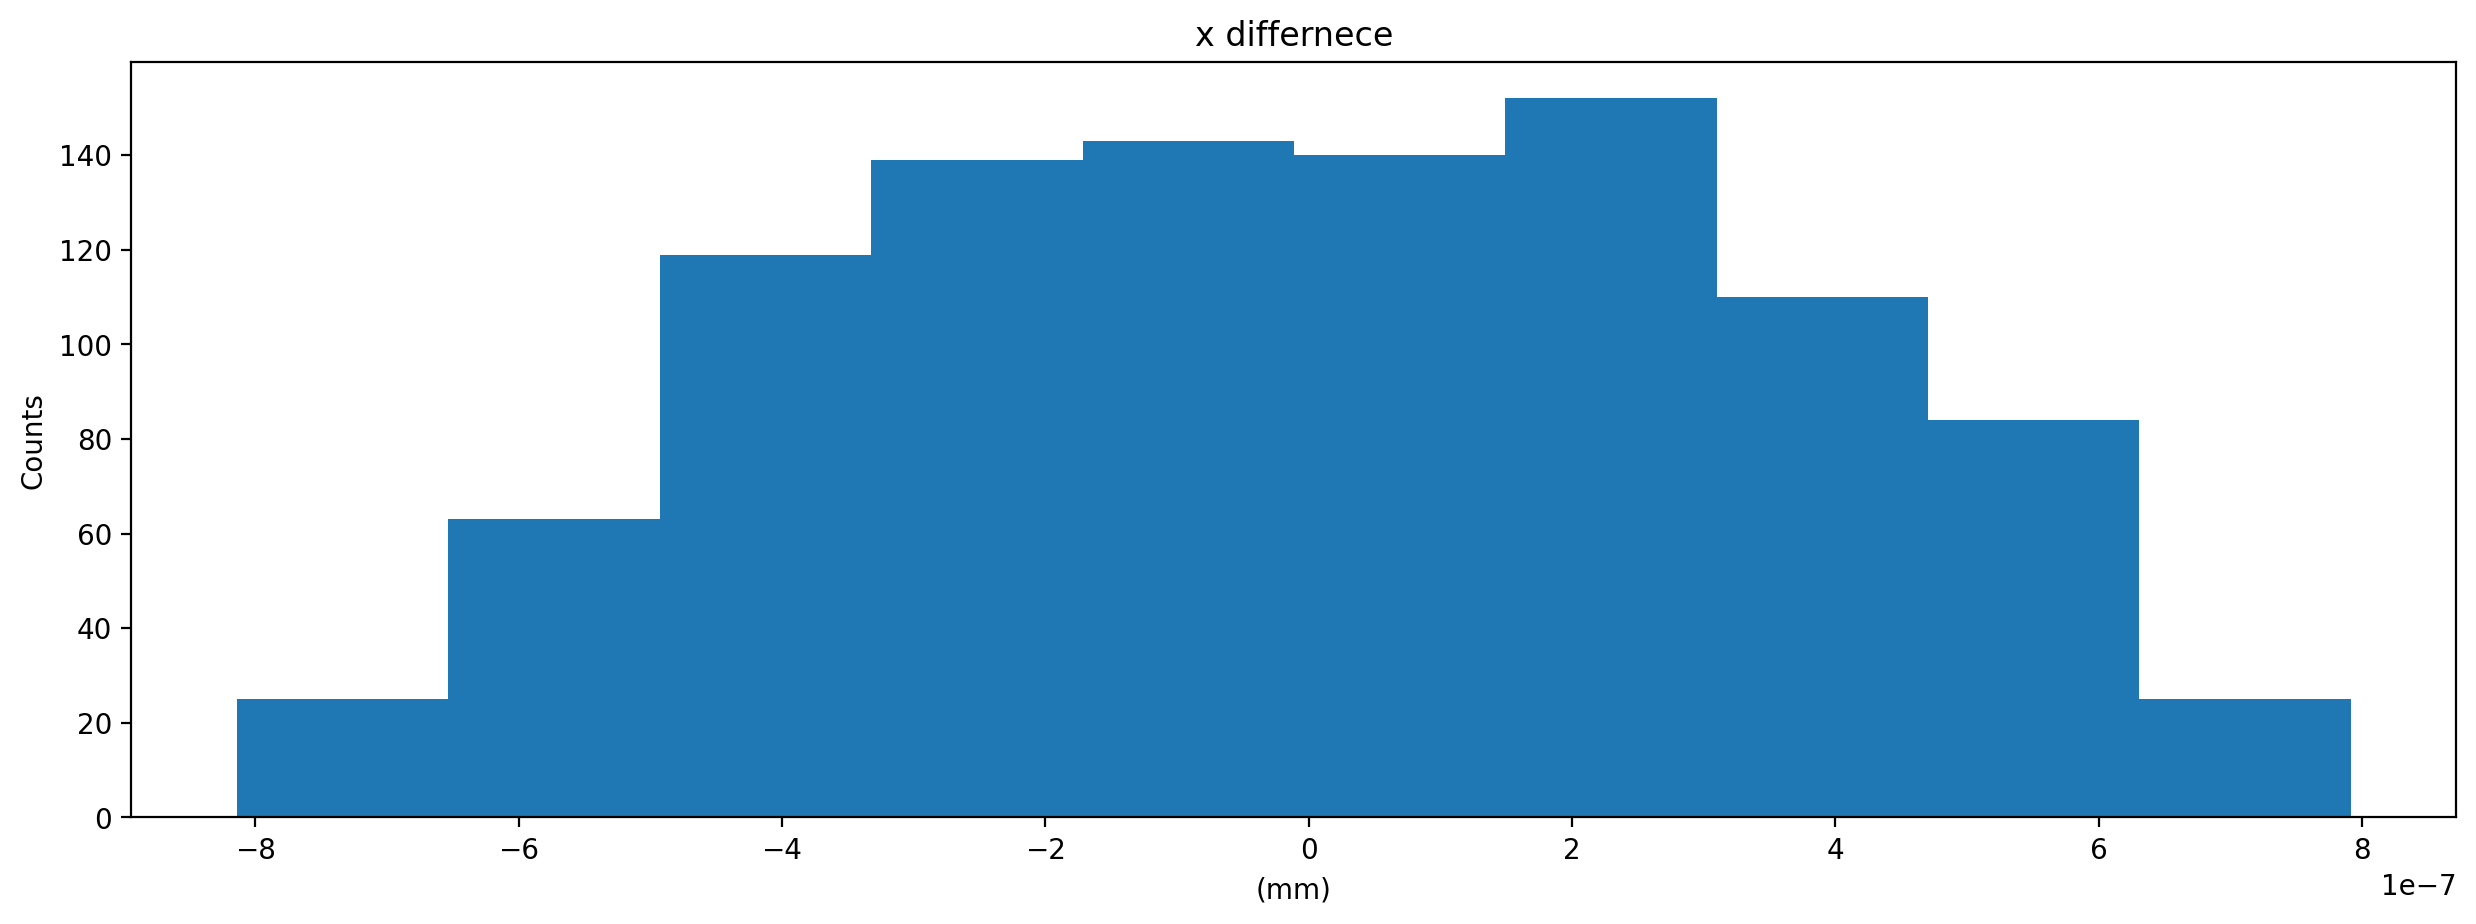

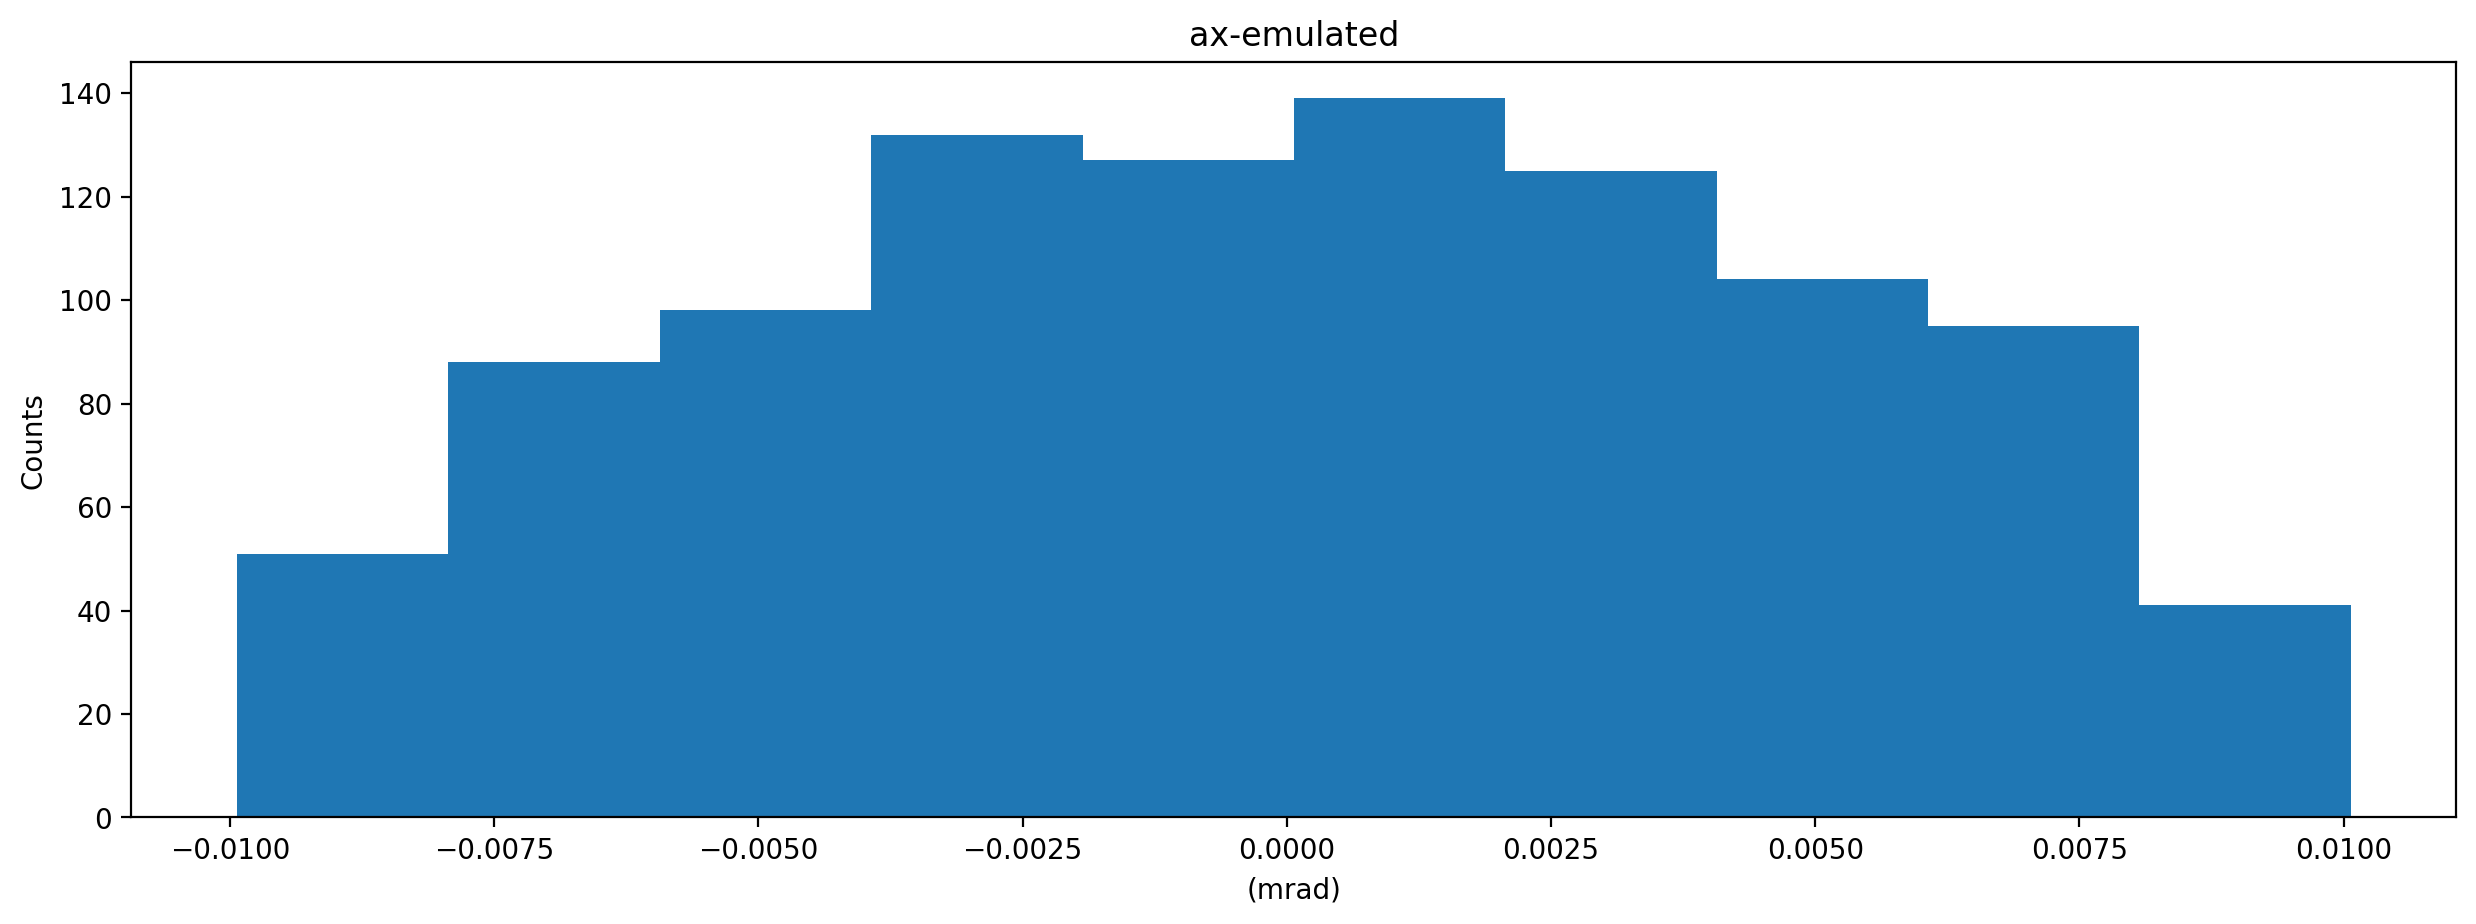

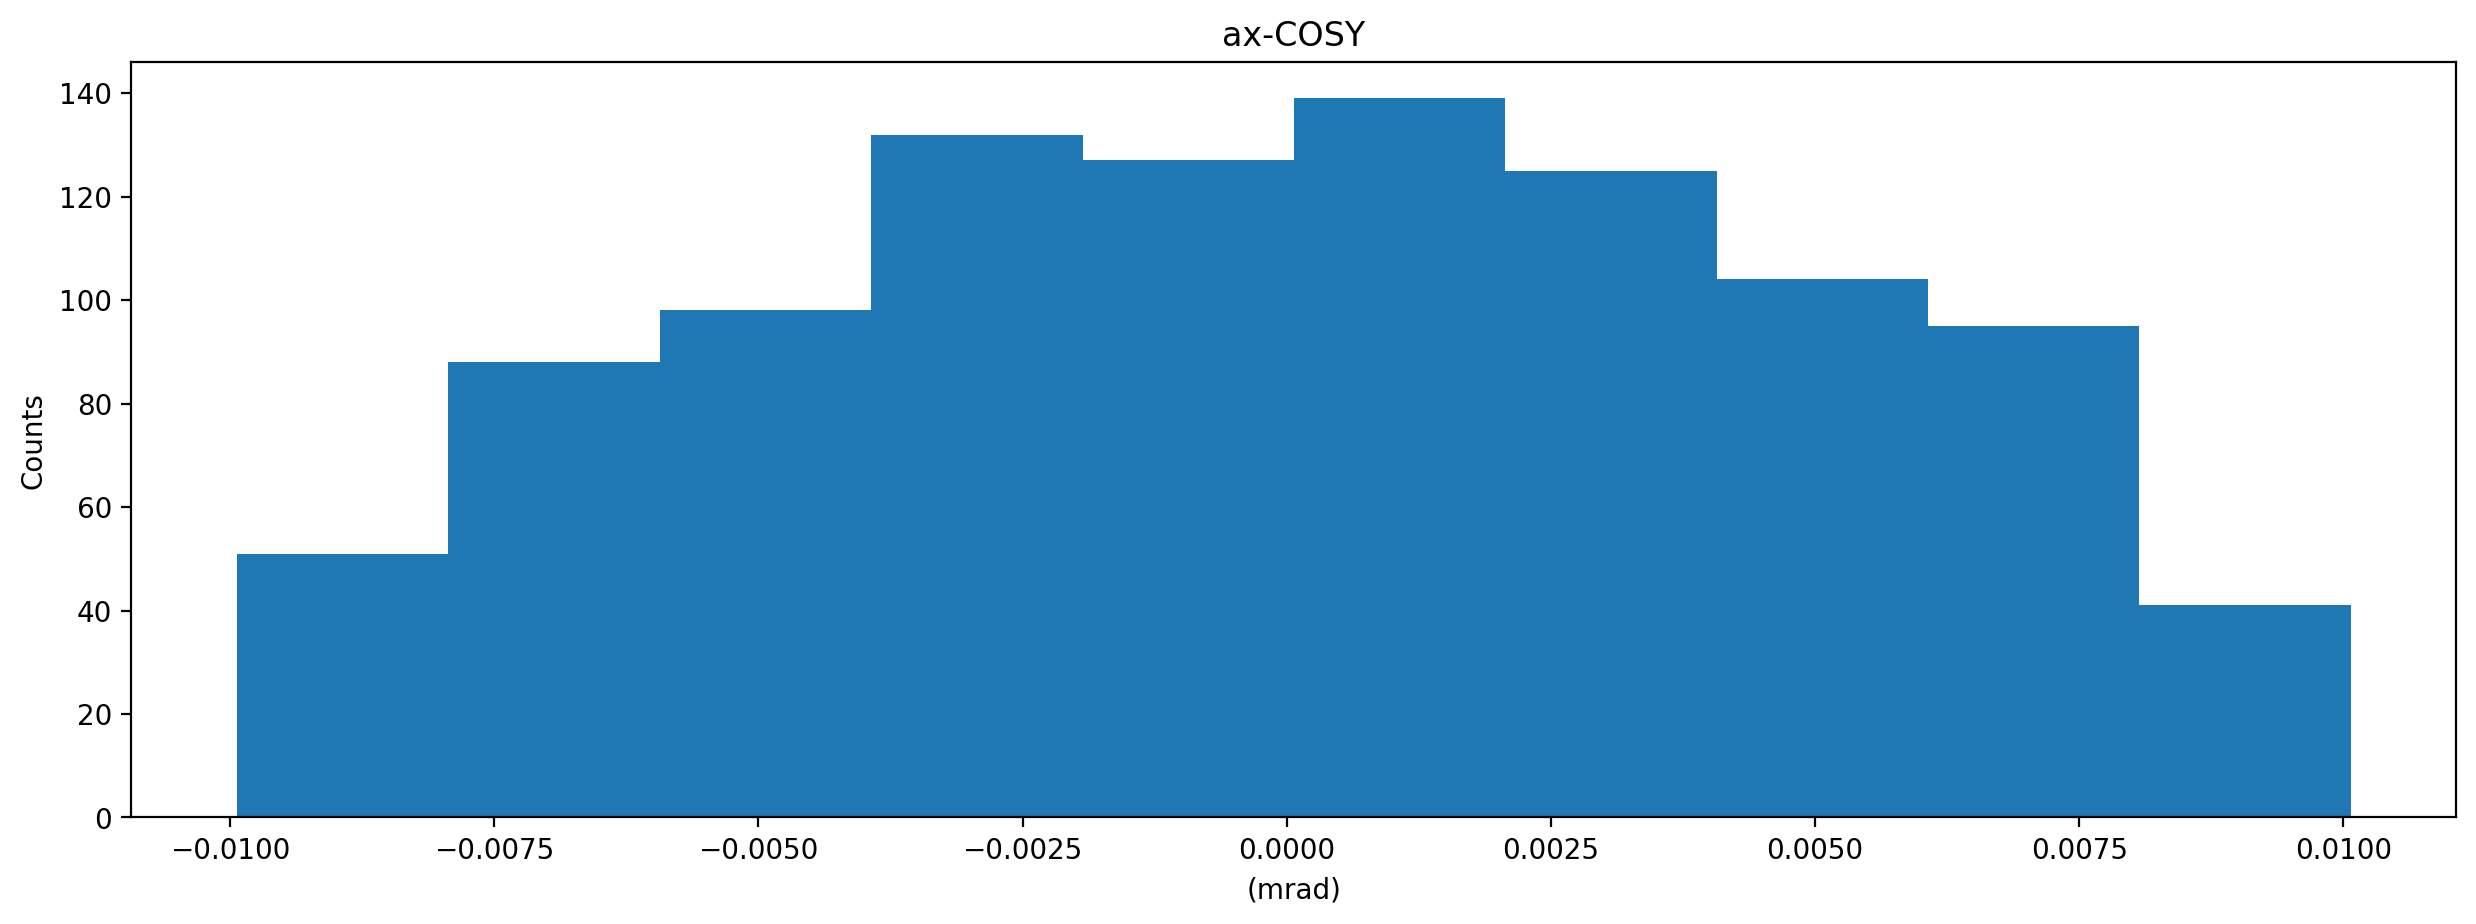

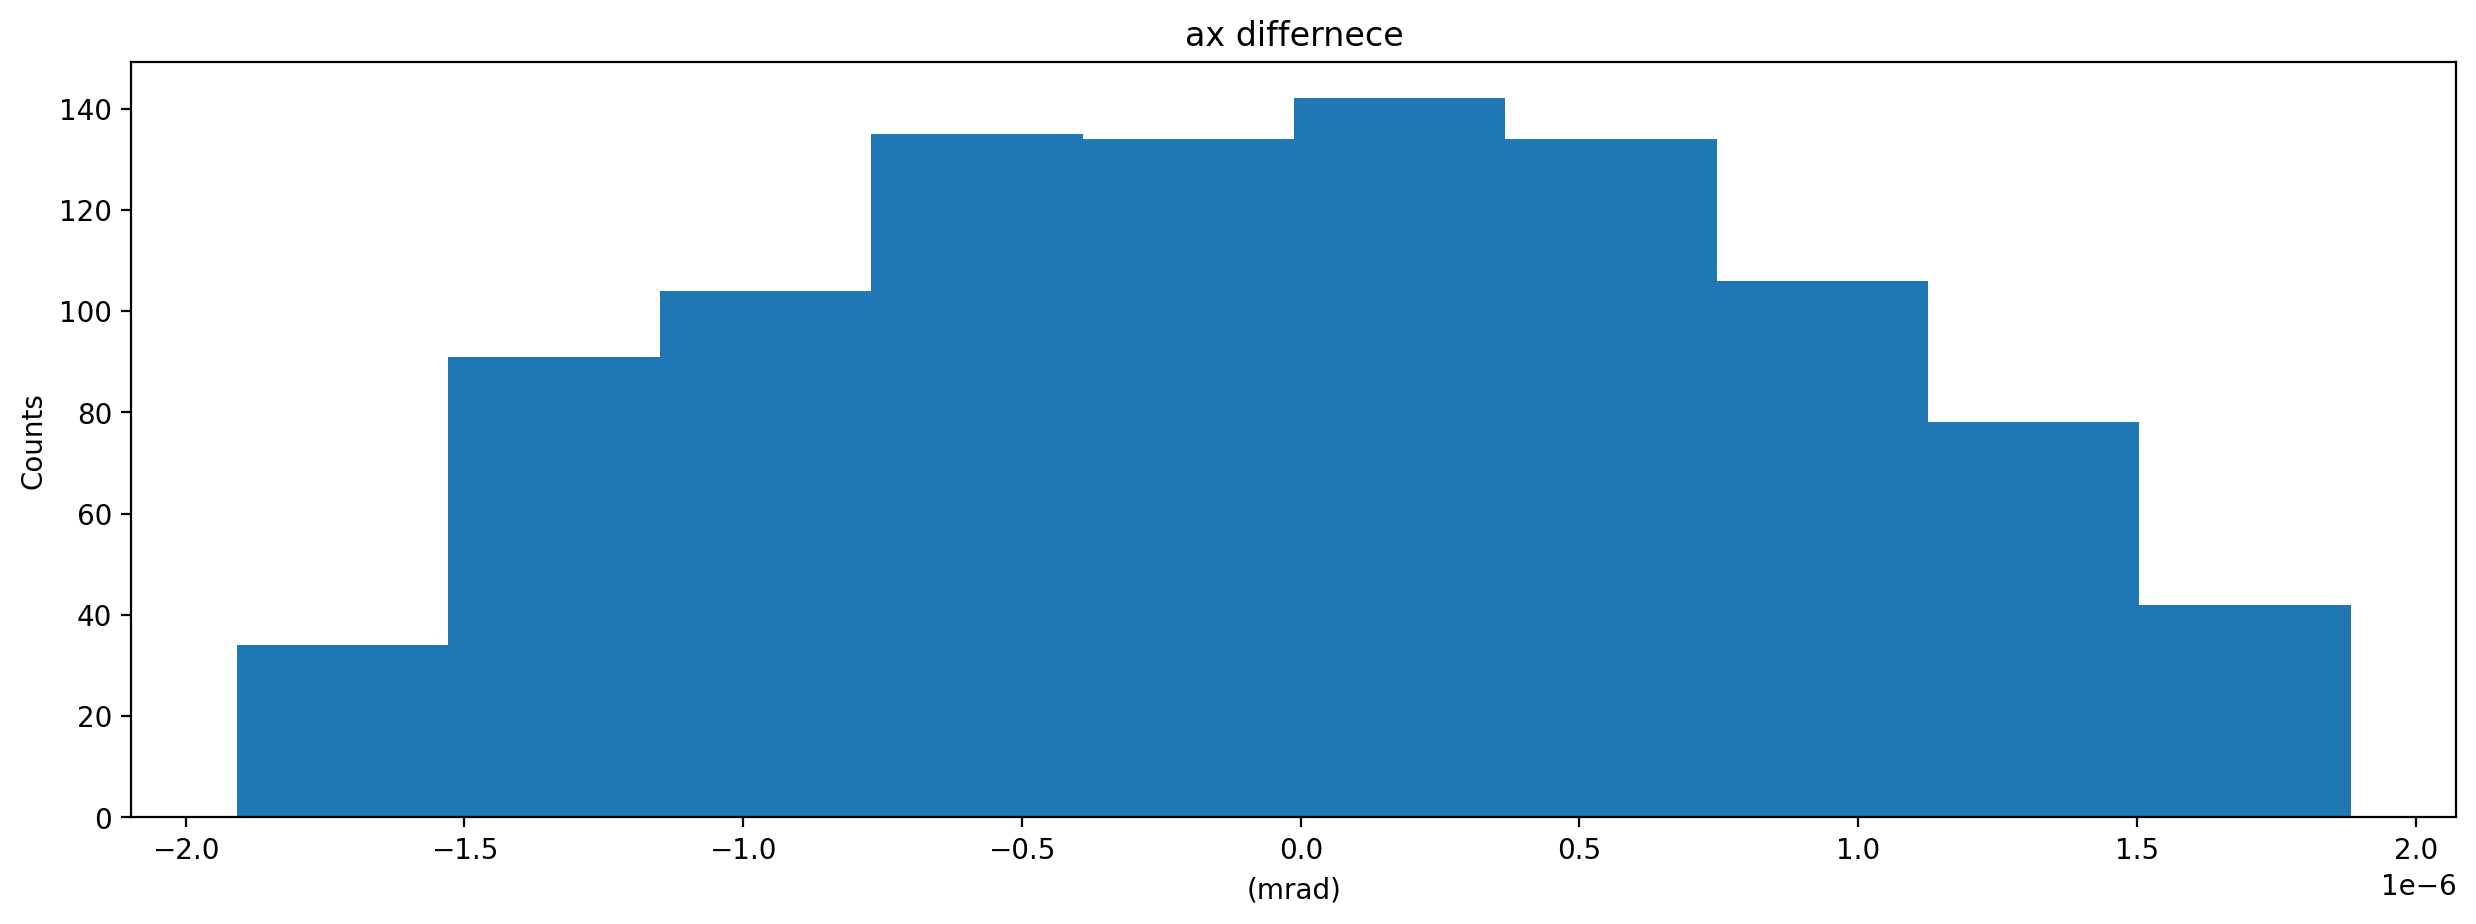

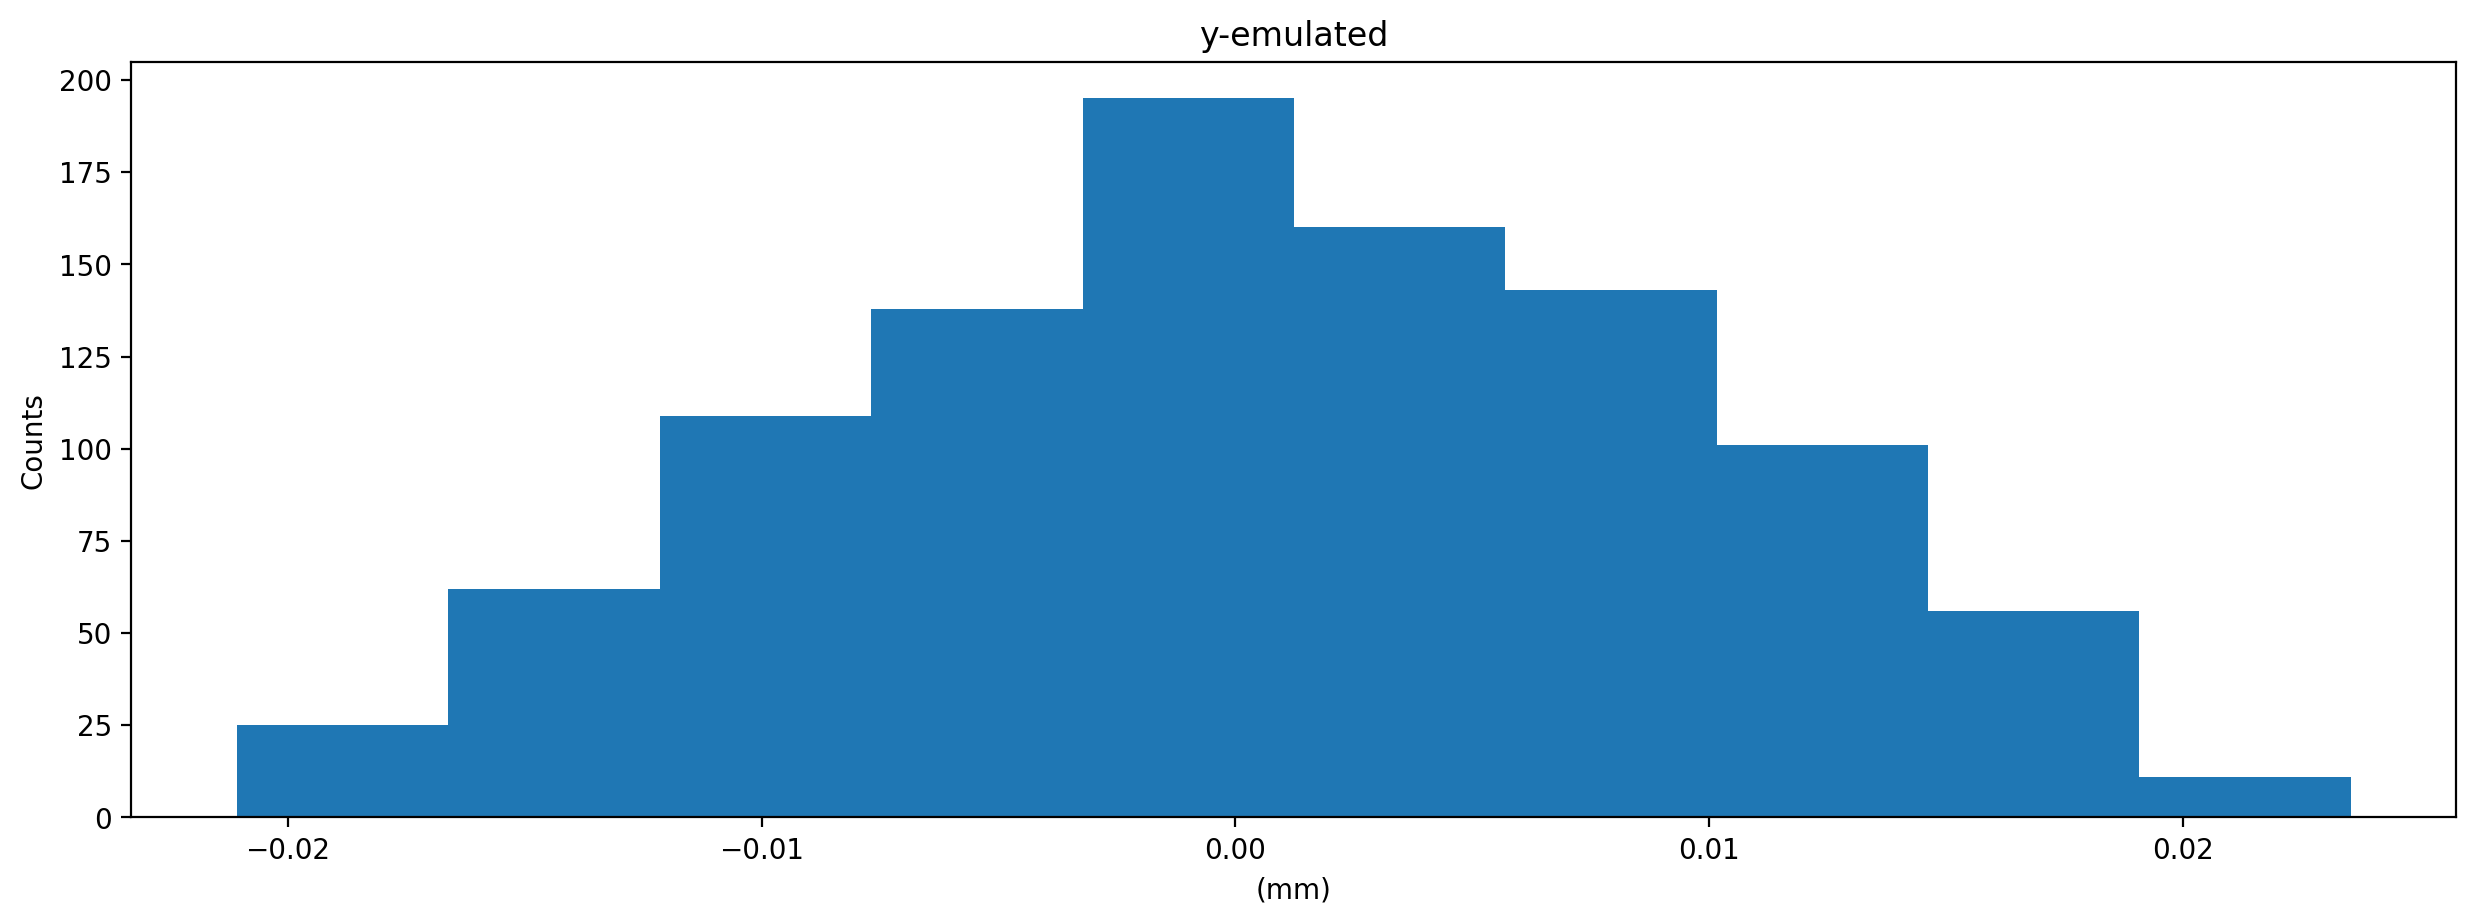

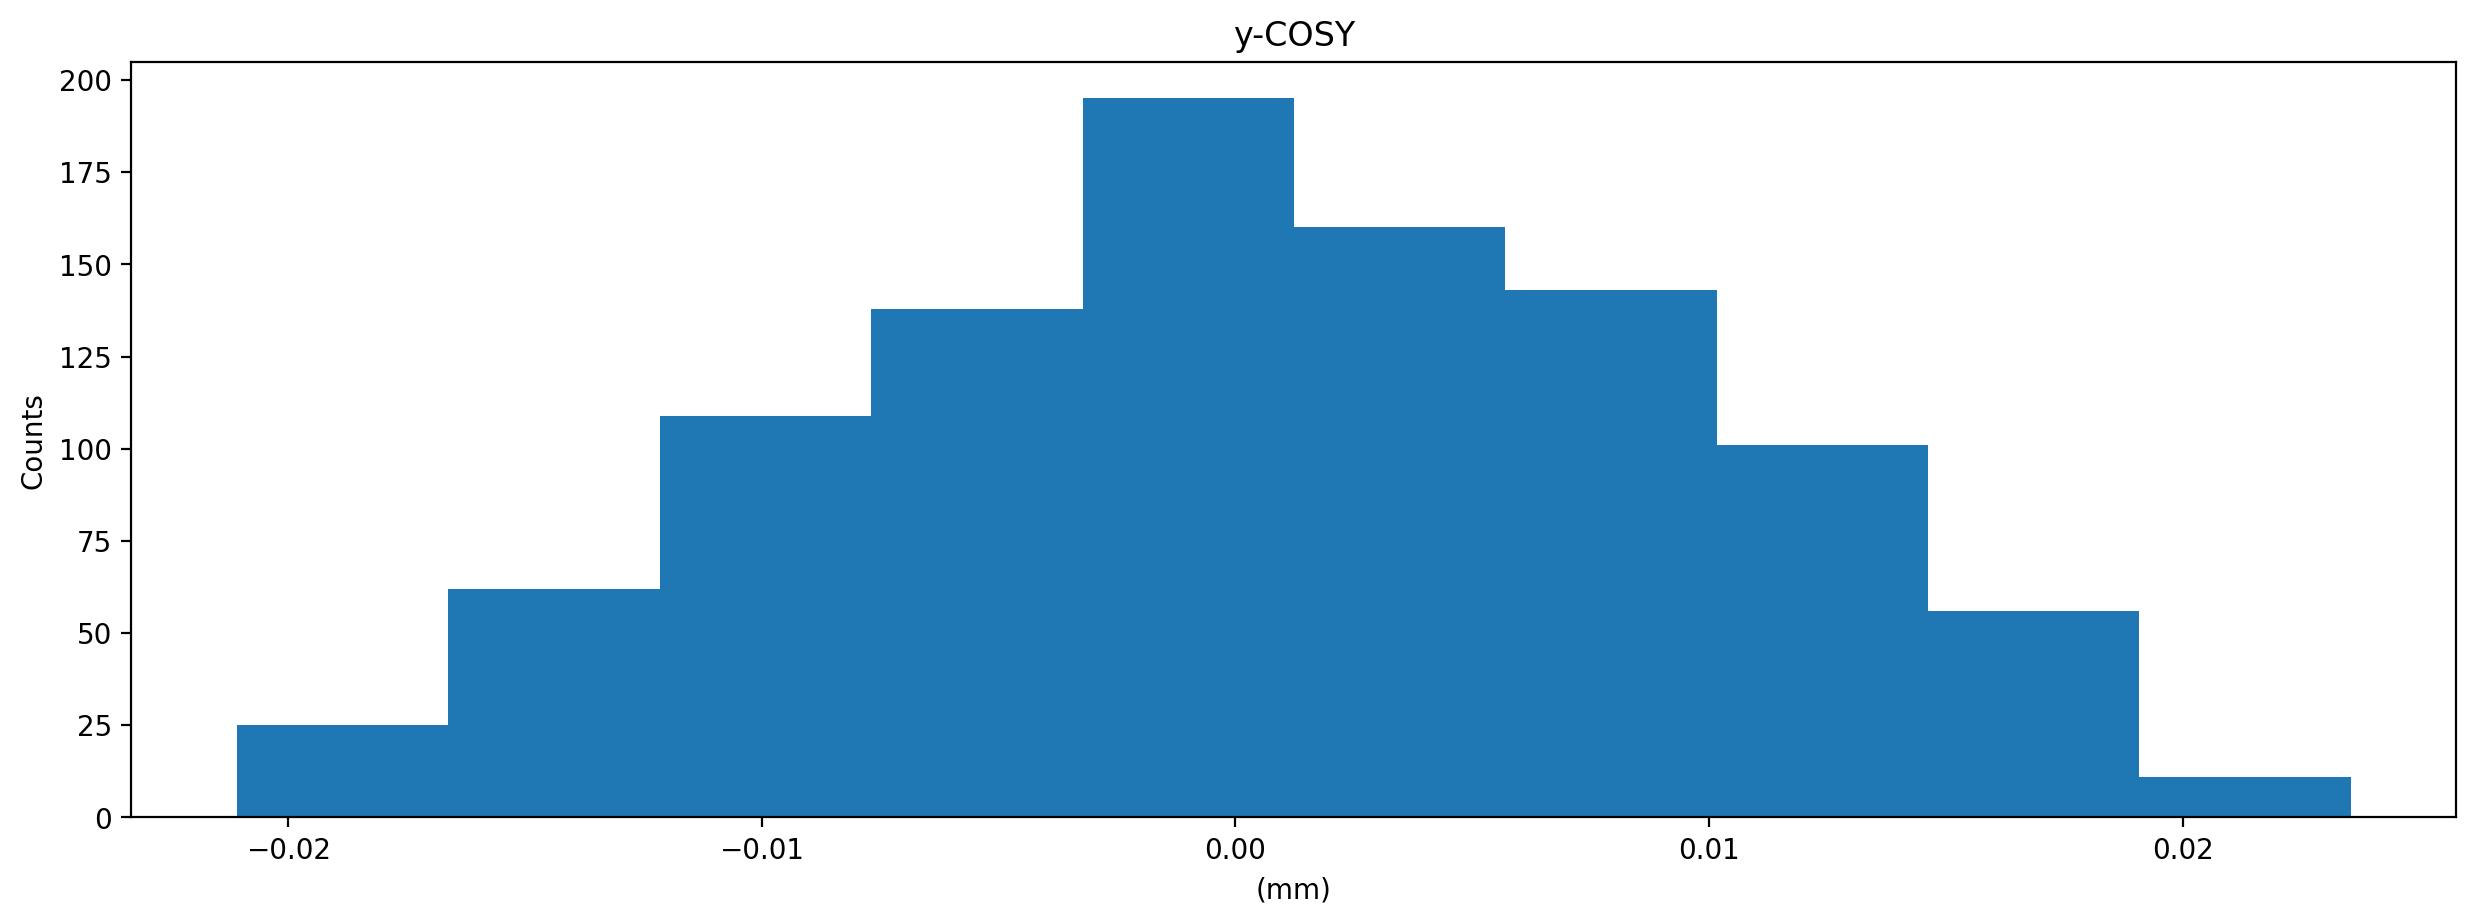

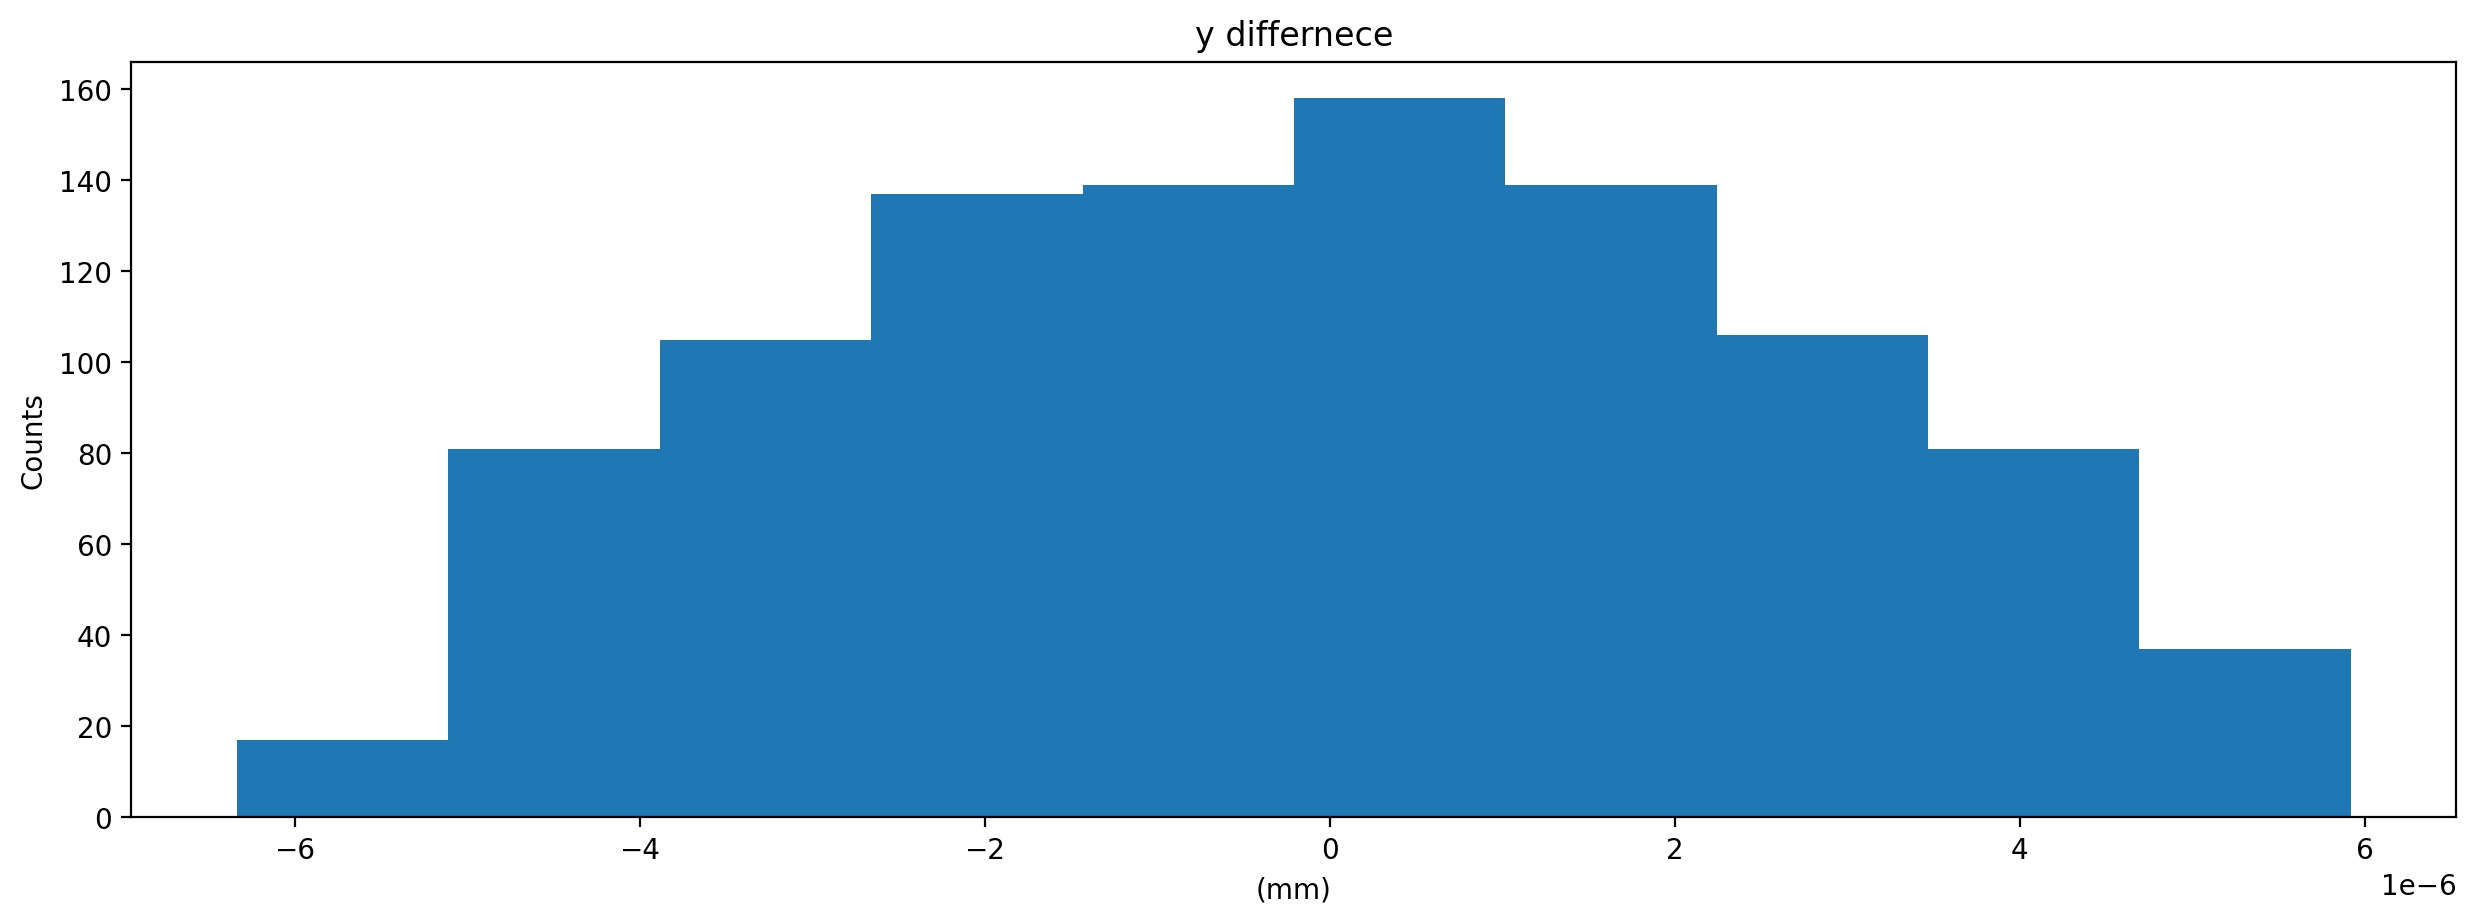

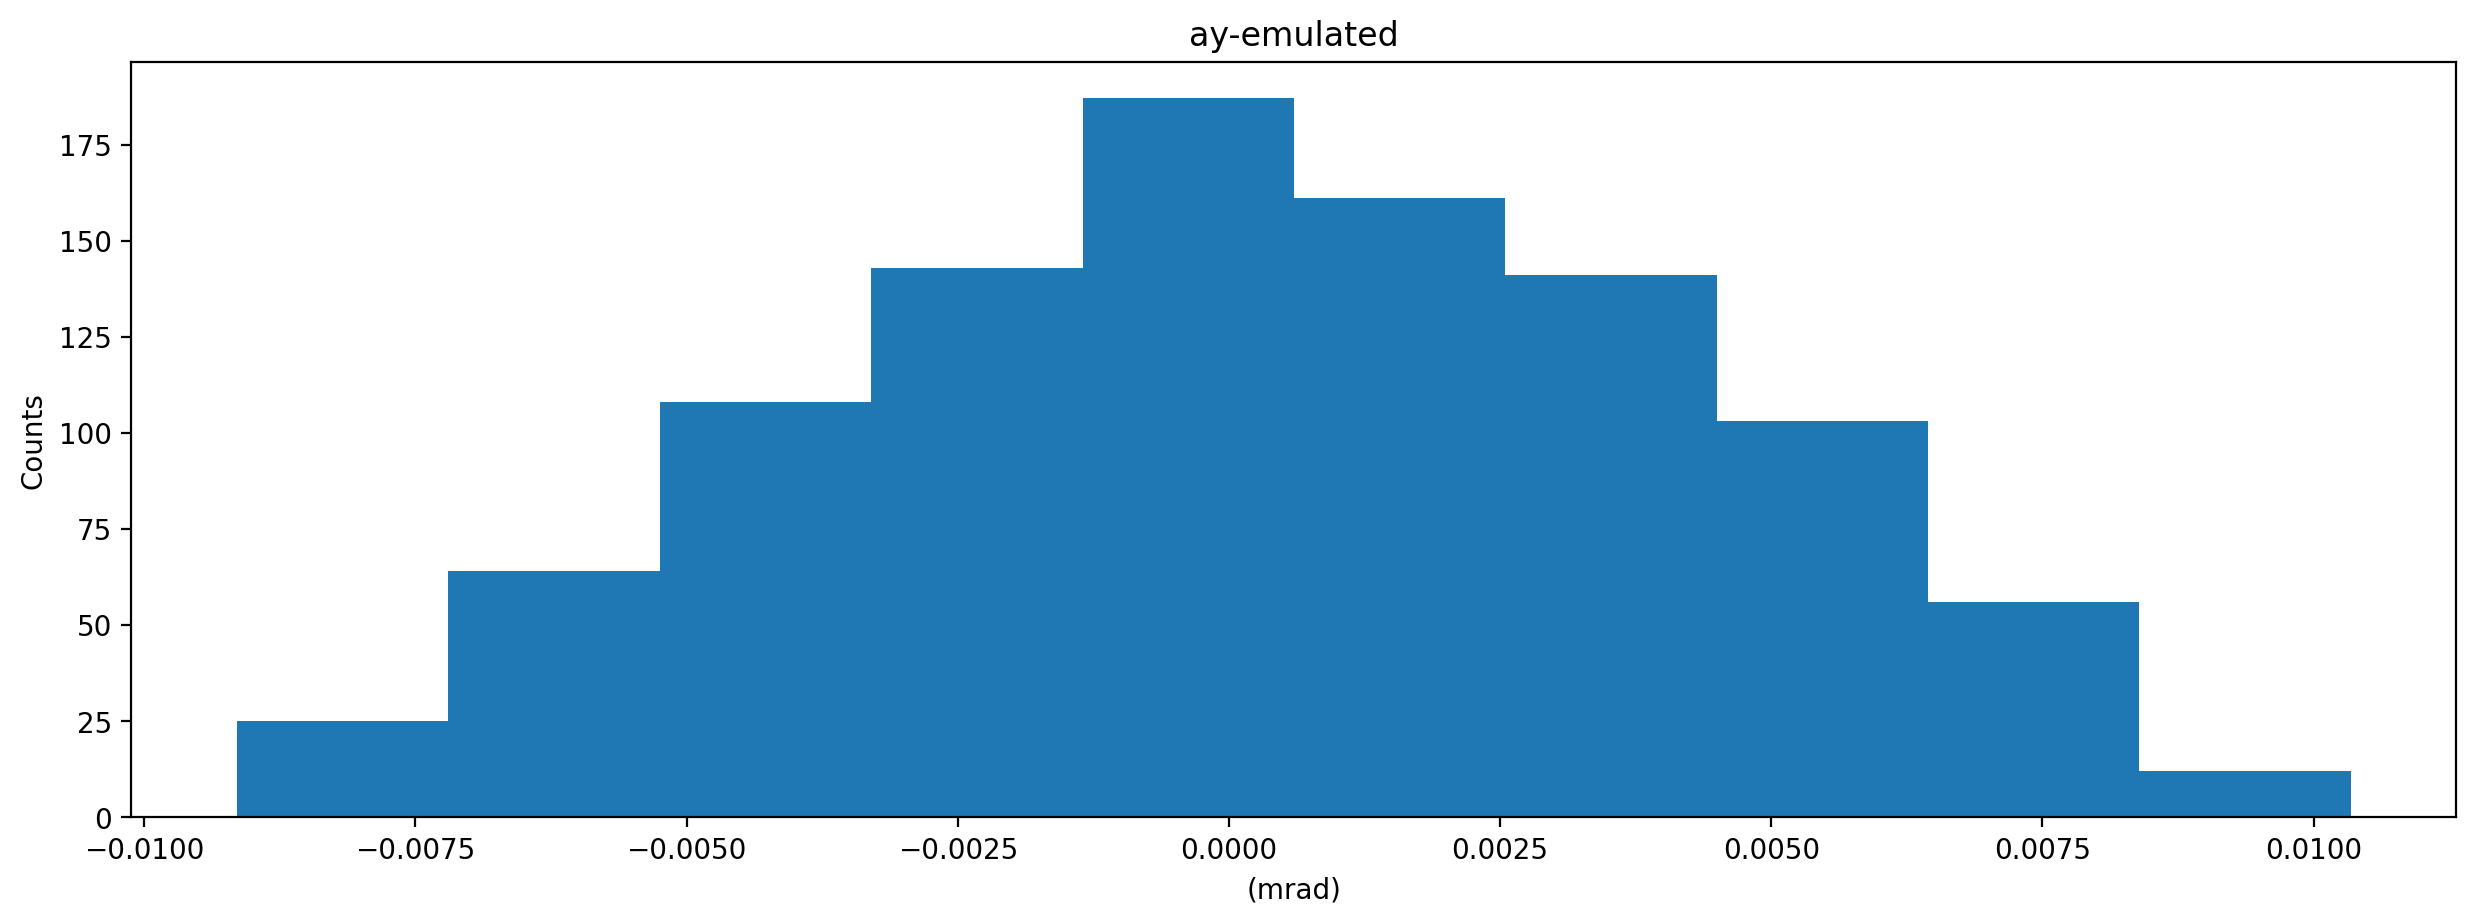

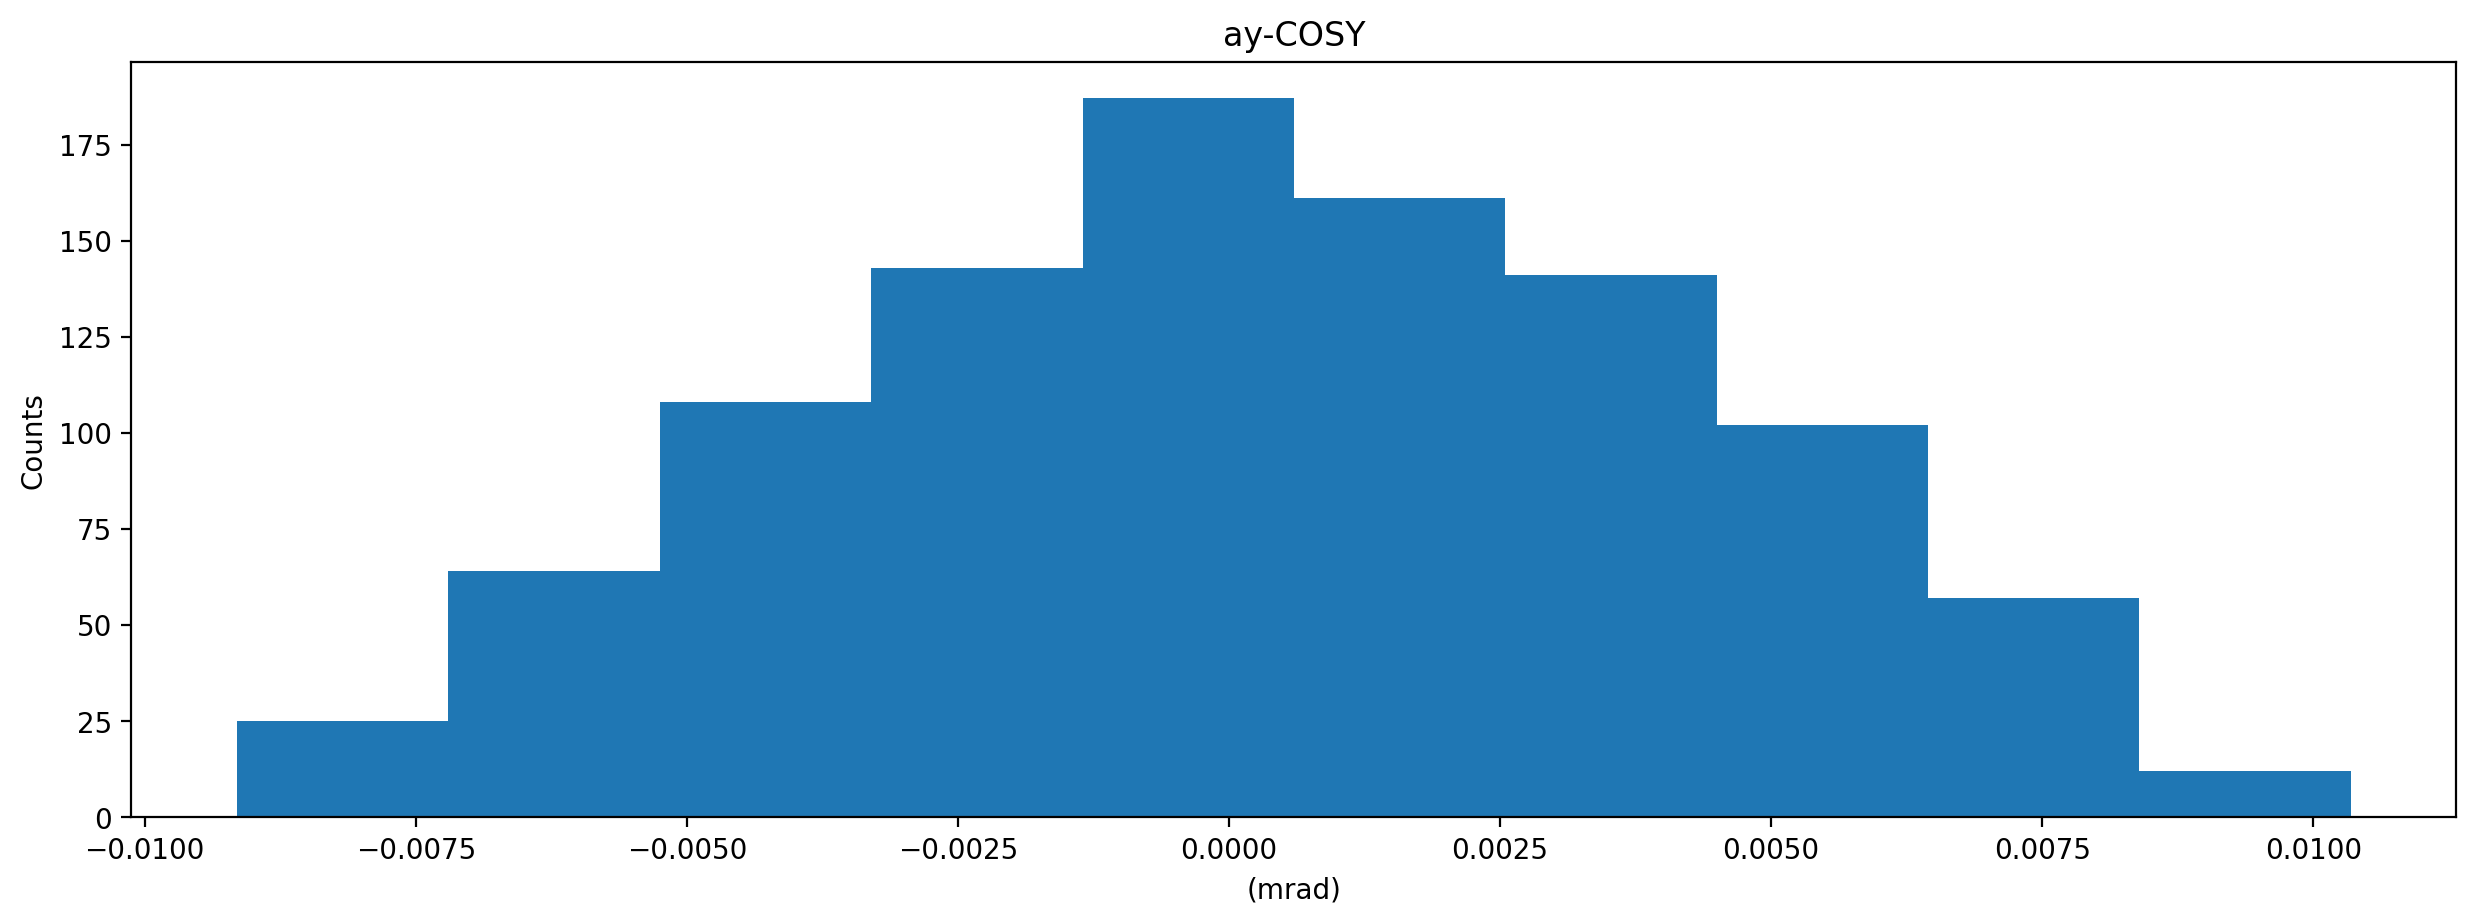

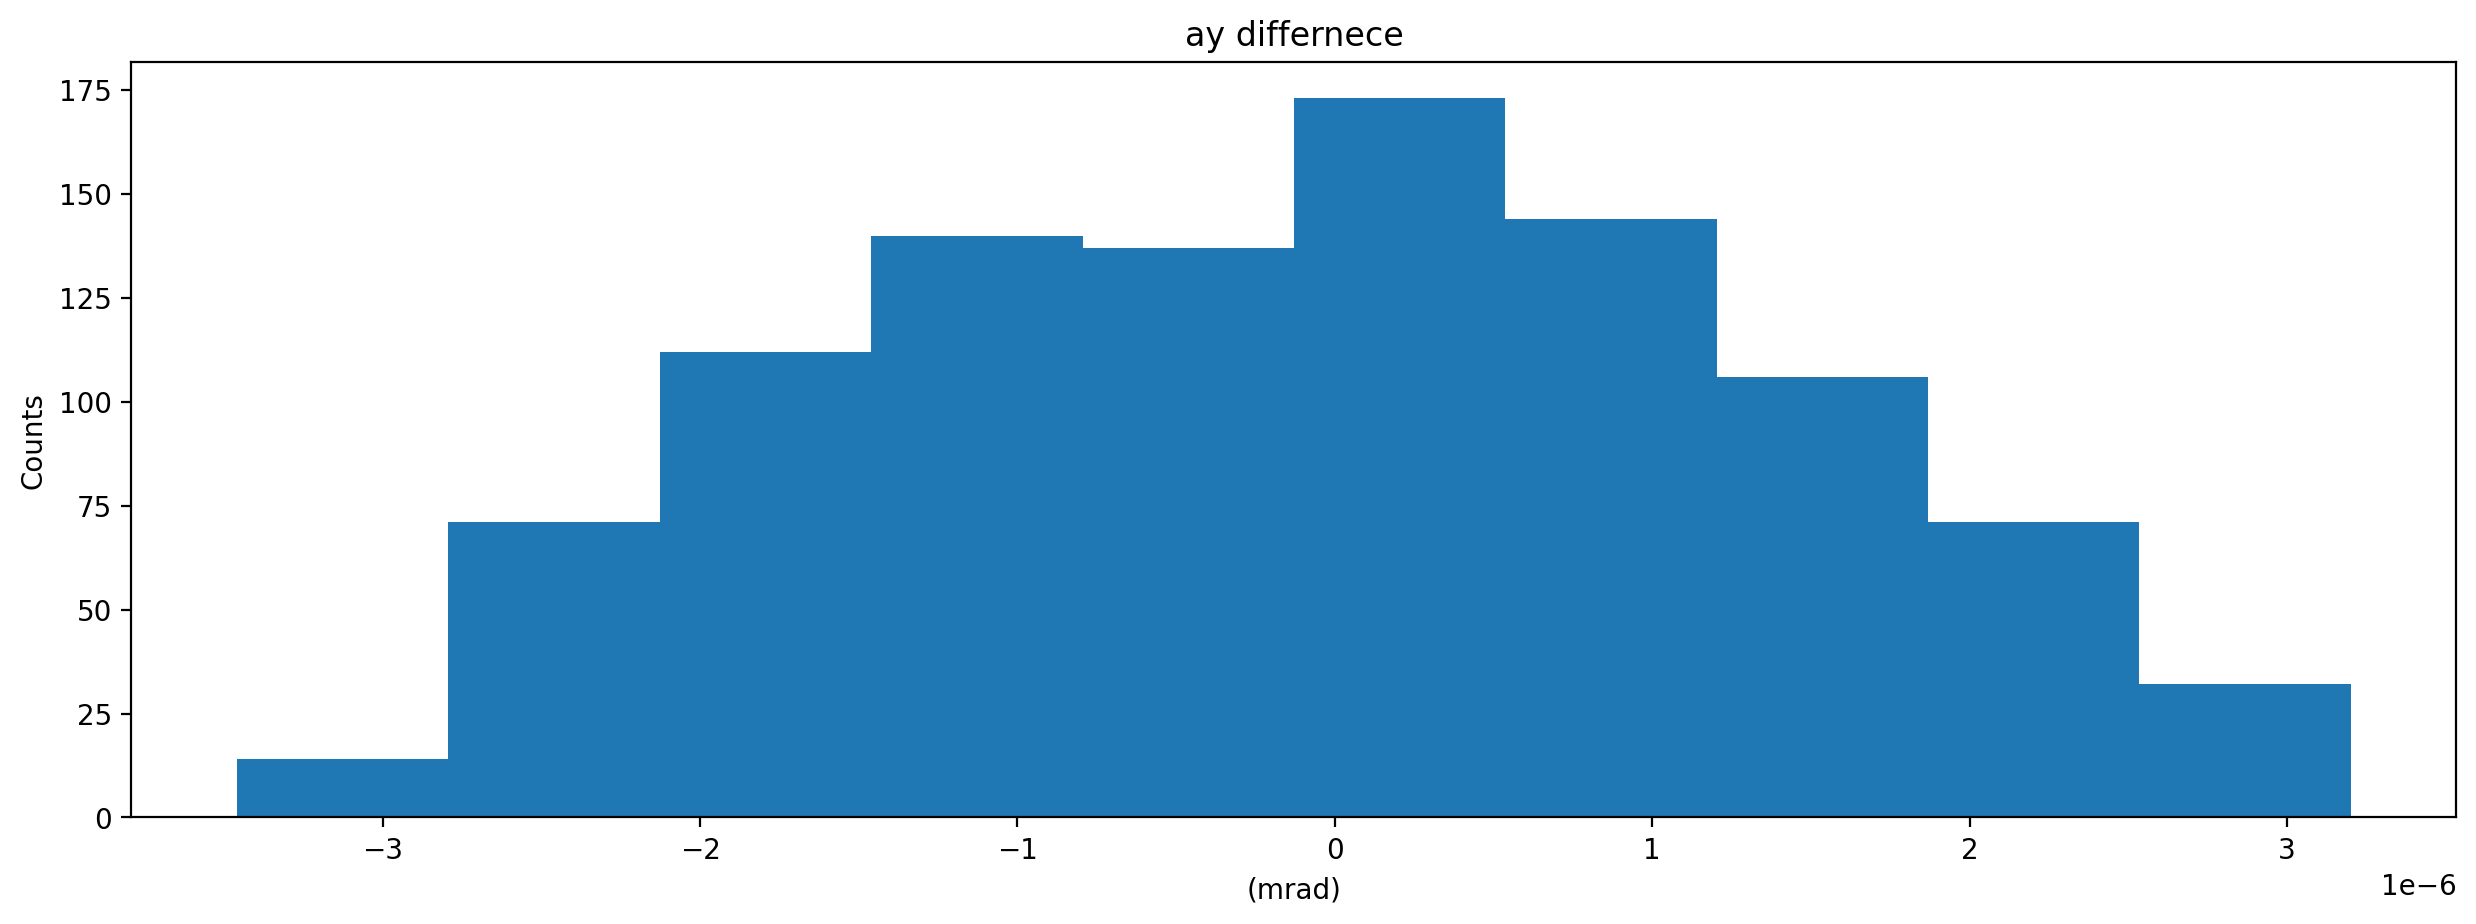

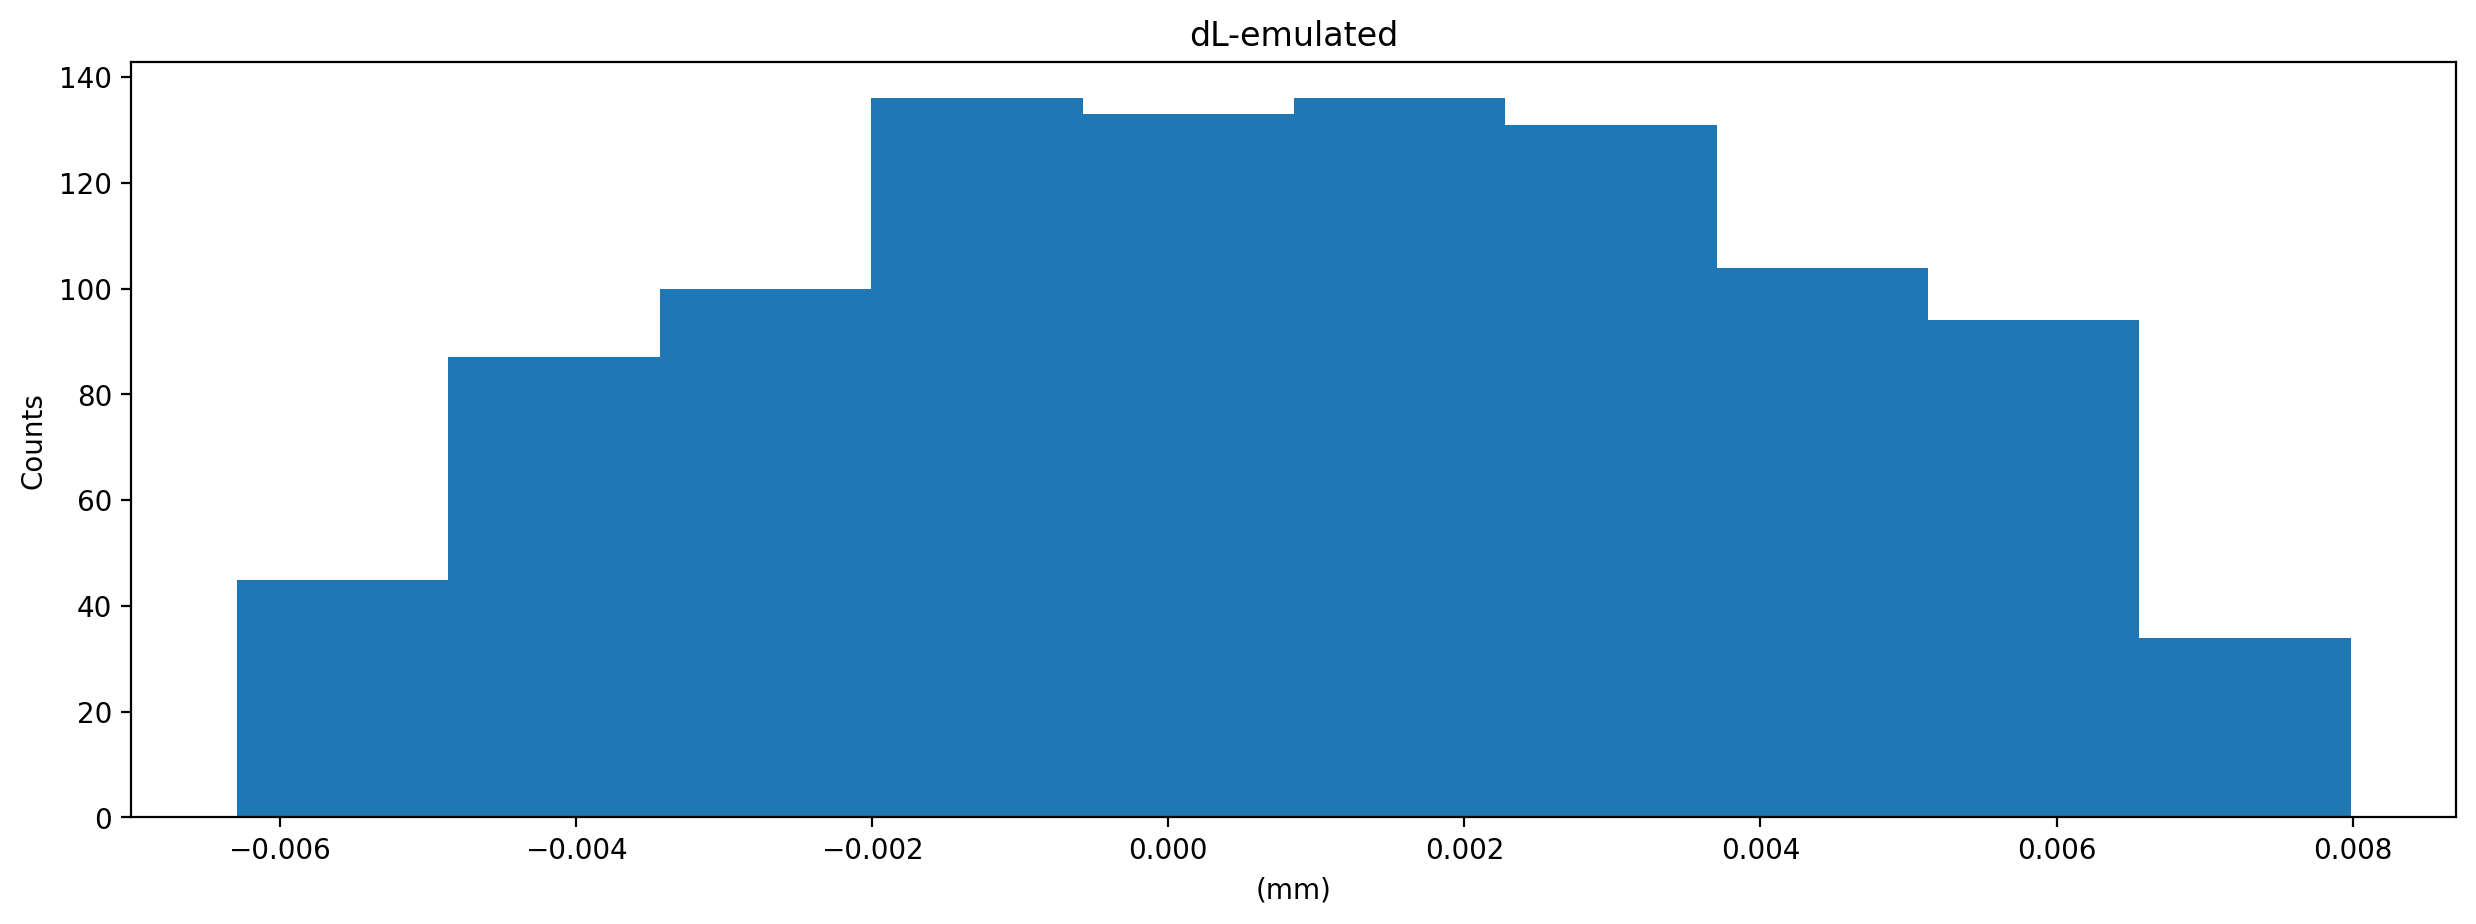

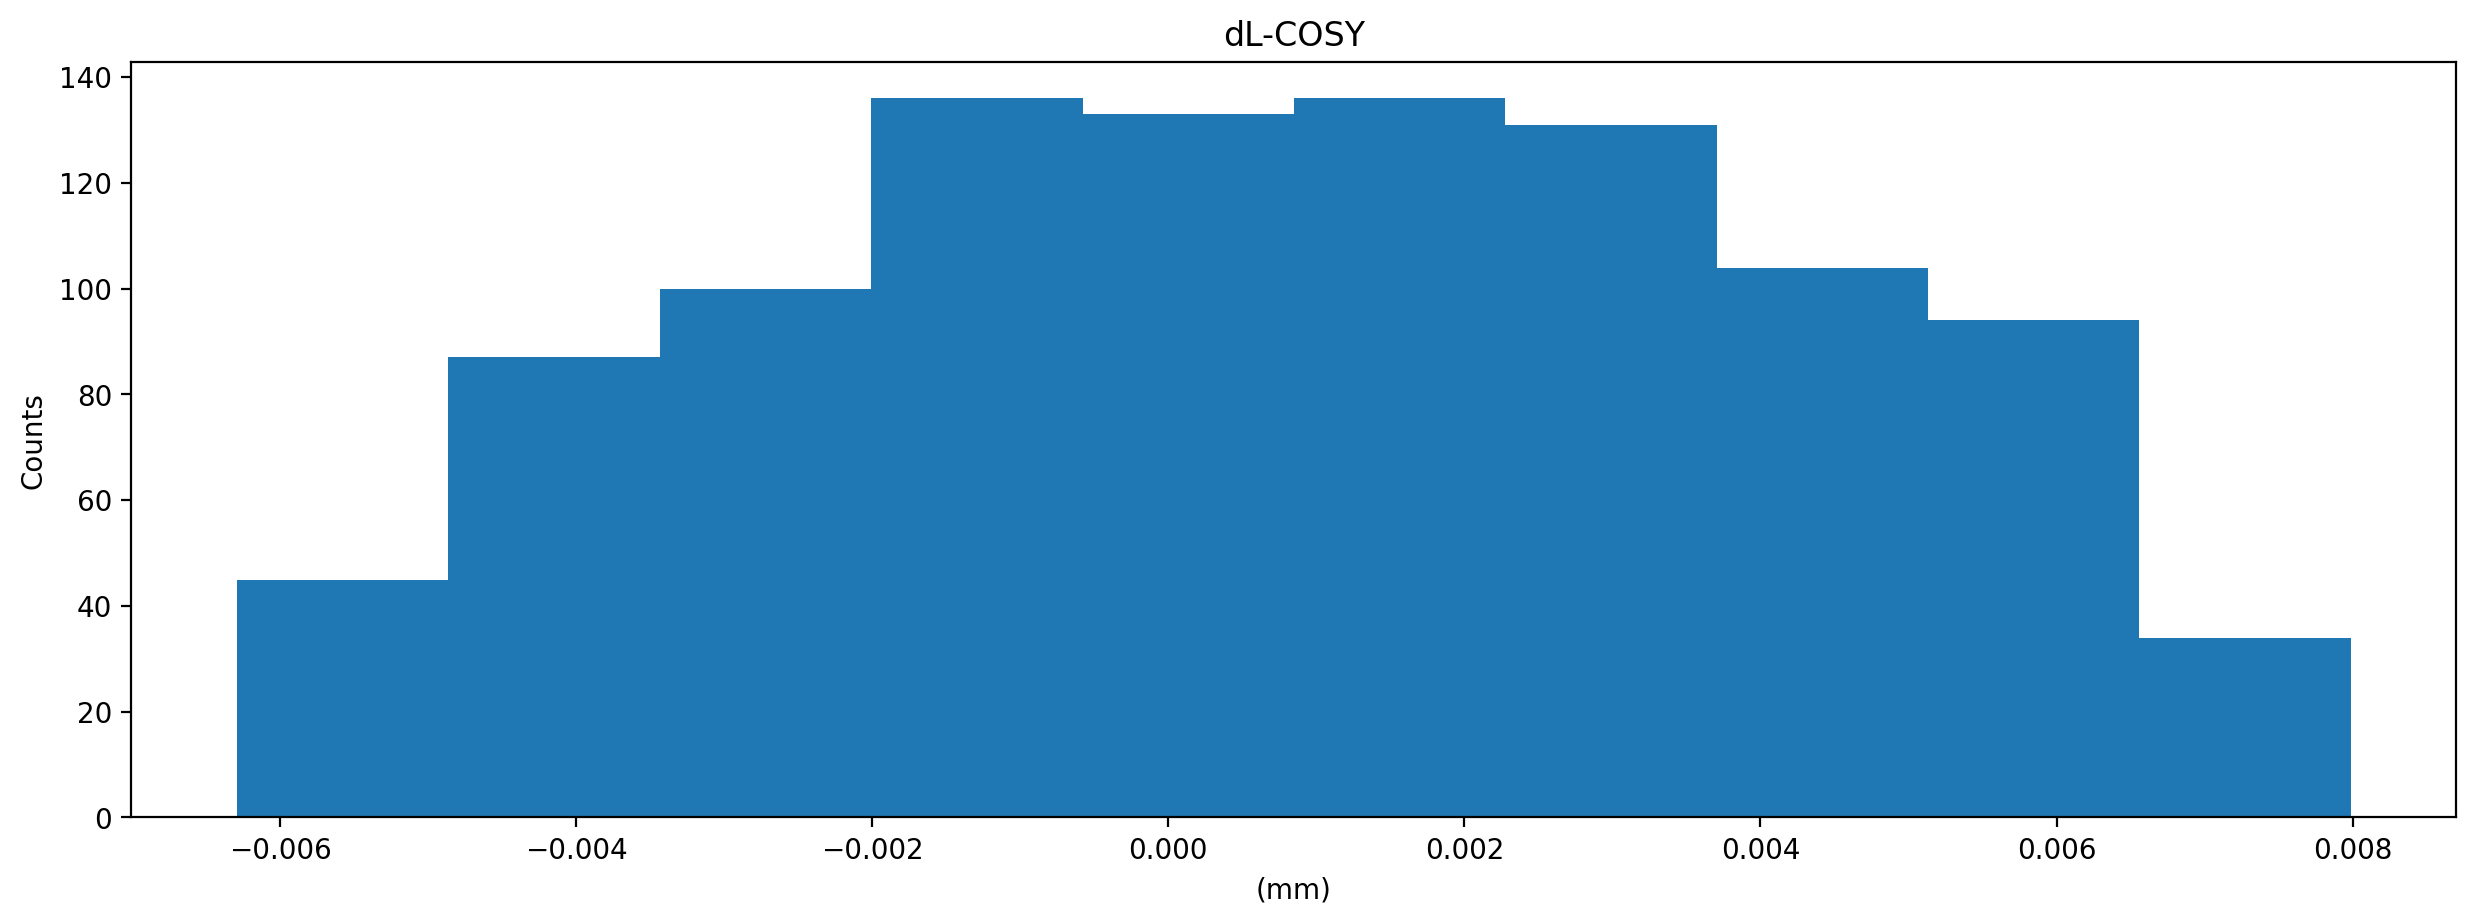

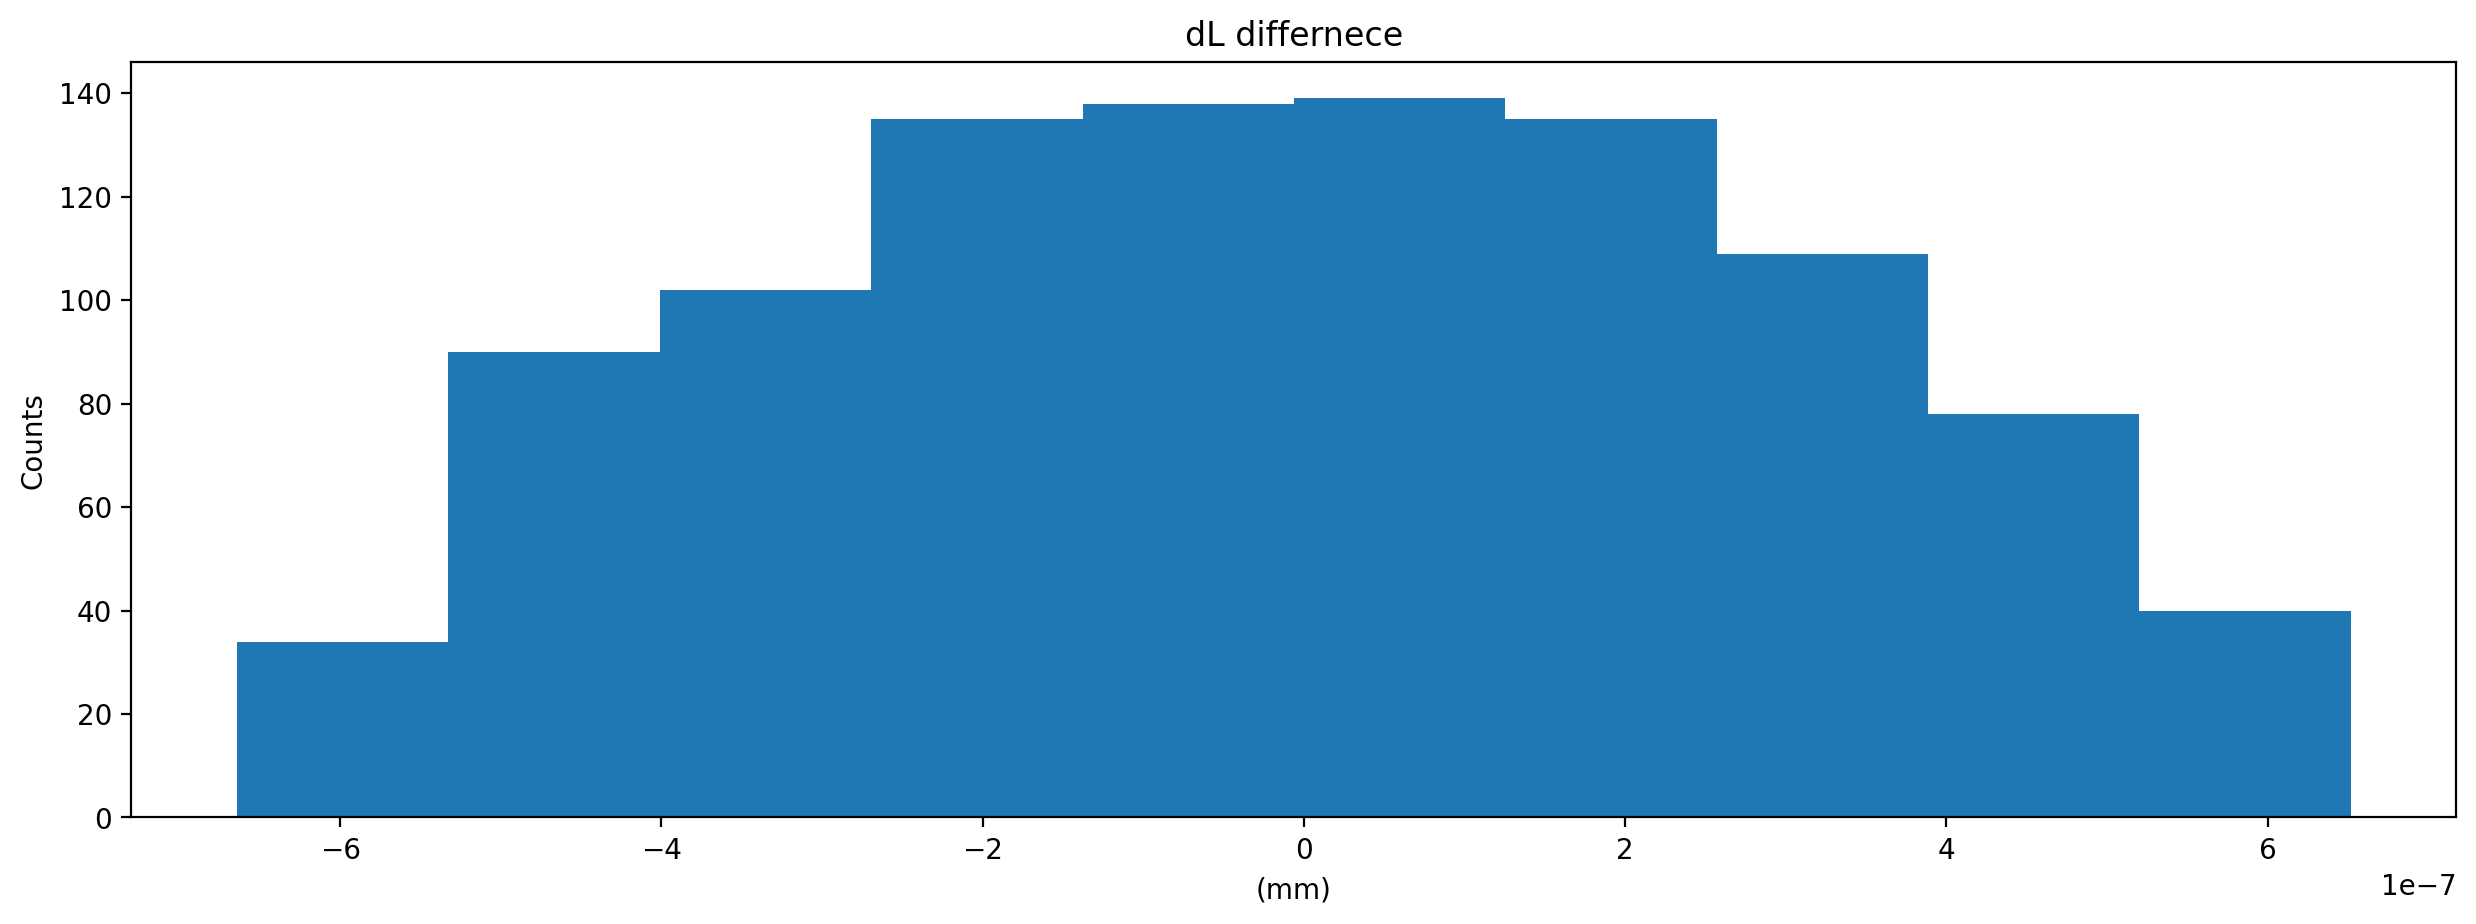

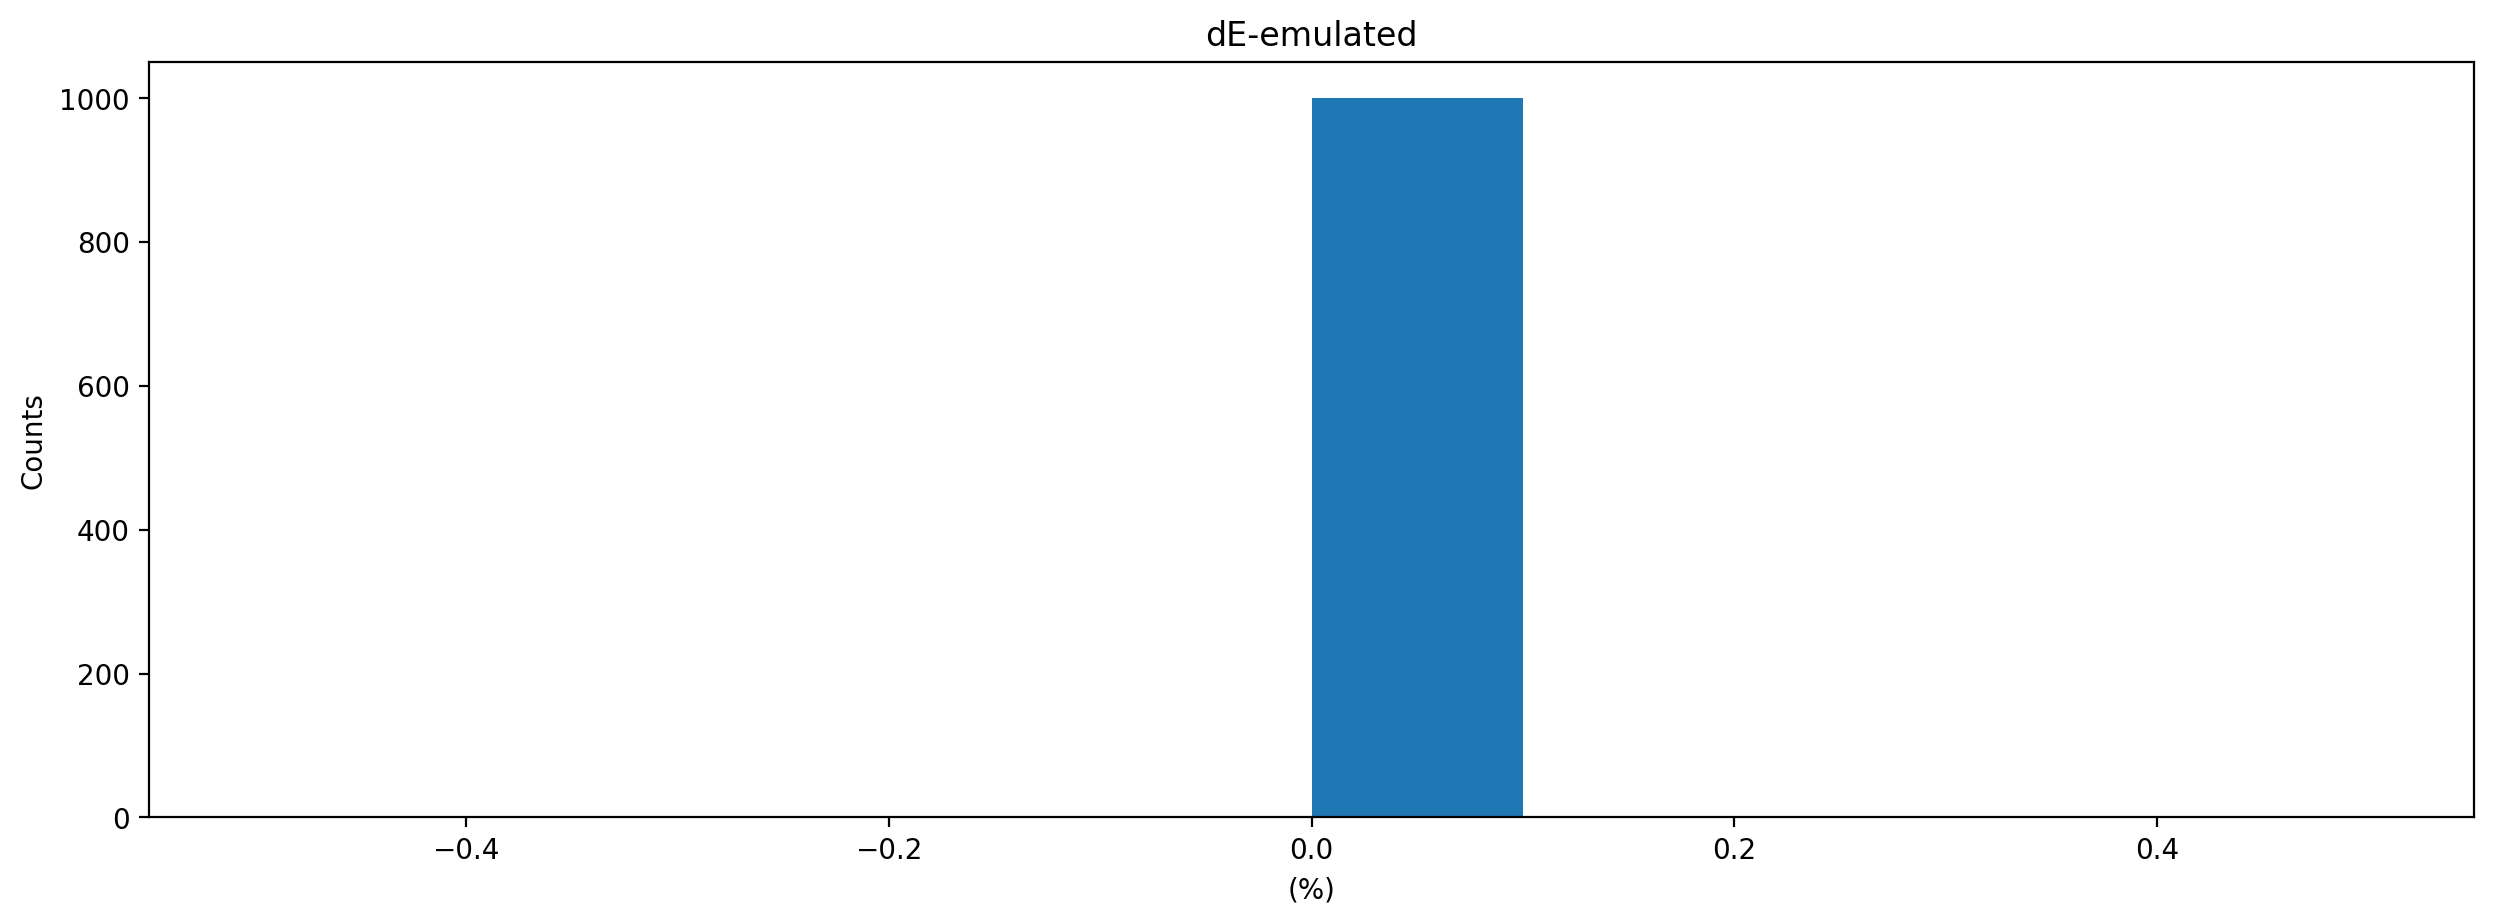

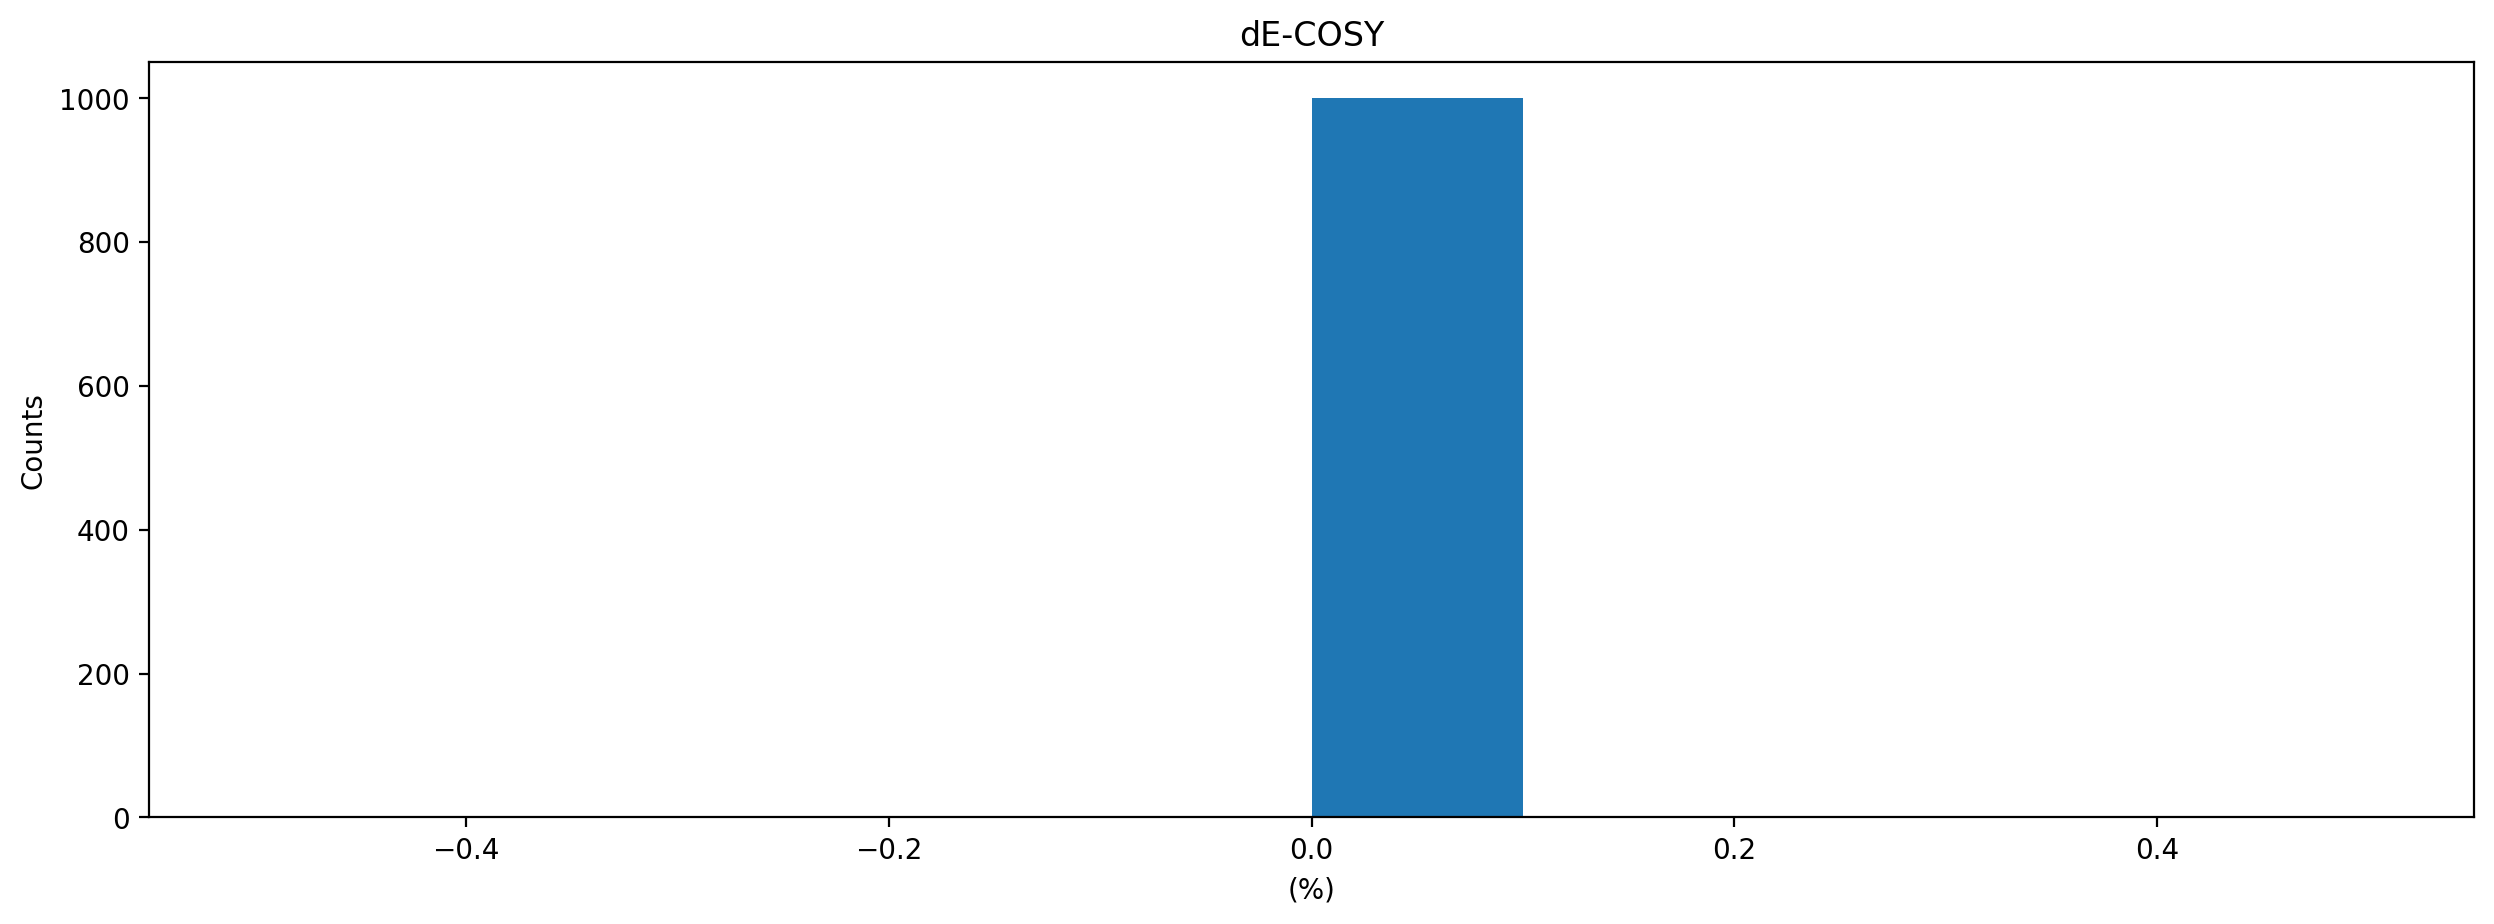

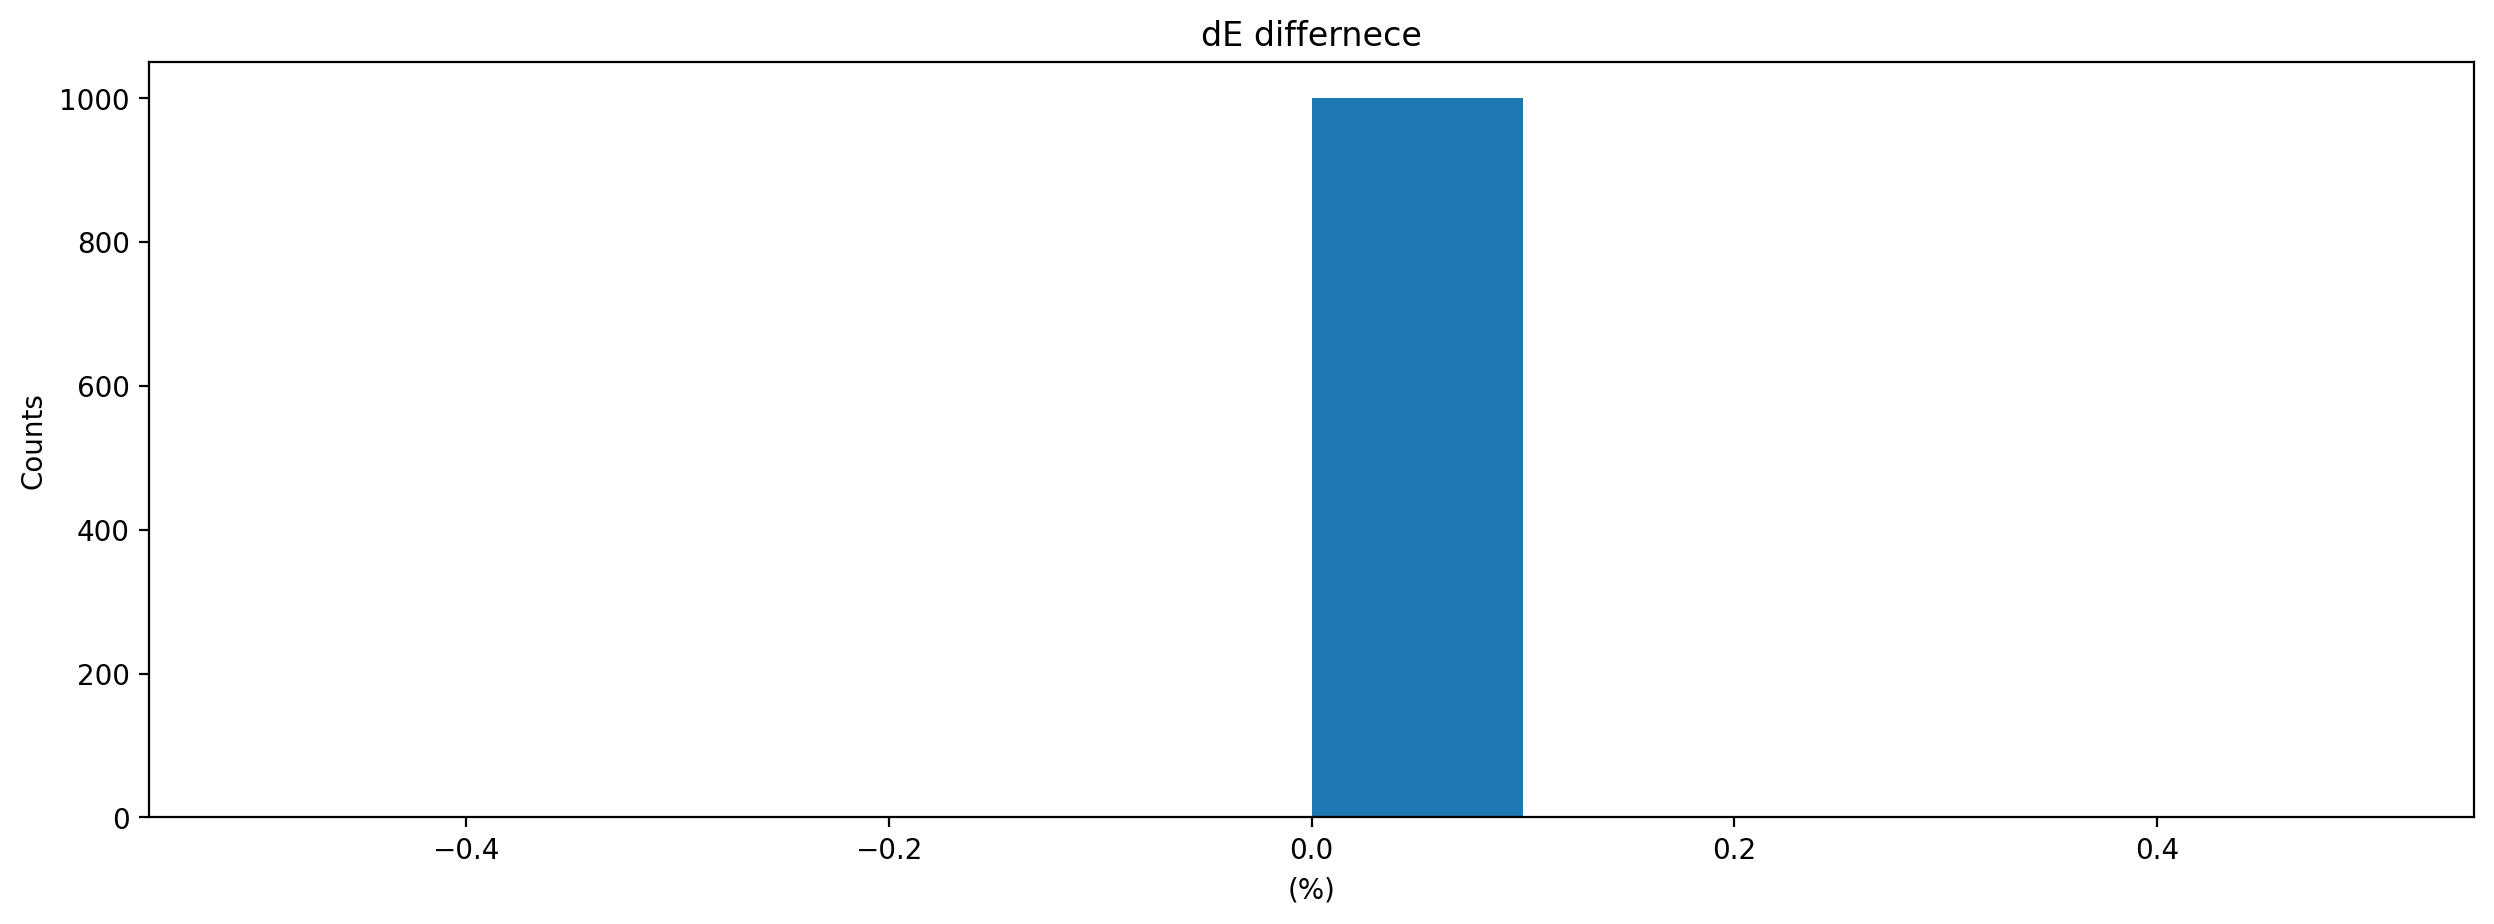

In [29]:
''' Initialize some beams '''
xh = 0 # center of x distribution in mm
yh = 0 # center of x distribution in mm
widthX = 1.5/2 # half x- beam spot in mm
widthY = 1.5/2 # half y- beam spot in mm
dE = 0.0025 # half of total energy spread in fraction 1% = 0.01
aX = 5 # mrad
aY = 5 # mrad

rays  = generateInitialDistribution(widthX,widthY,aY,aY)

''' Evolve both using emulated and lookup magnets '''
currents = [ float(s['current']) for s in settings ]

emul_beams_out = dynamic_secar.emulate(rays=rays,currents=currents)
hfid_beams_out = static_secar.emulate(rays=rays,currents=currents)

''' Display deviations '''
chars = [ {"title" : "x", "unit":"(mm)"}, 
          {"title": "ax", "unit":"(mrad)"}, 
          {"title": "y", "unit":"(mm)"}, 
          {"title": "ay", "unit":"(mrad)"},
          {"title": "dL", "unit":"(mm)"}, 
          {"title": "dE", "unit":"(%)"}, 
        ]
for i in range(len(chars)):
    
    ''' Emulated '''
    fig, ax = plt.subplots(dpi=200)
    fig.patch.set_facecolor('white')
    ax.hist(emul_beams_out.transpose()[i])
    plt.title(chars[i]["title"]+"-emulated")
    plt.ylabel("Counts")
    plt.xlabel(chars[i]["unit"])
    plt.show()
    
    ''' High-Fidelity '''
    fig, ax = plt.subplots(dpi=200)
    fig.patch.set_facecolor('white')
    ax.hist(hfid_beams_out.transpose()[i])
    plt.title(chars[i]["title"]+"-COSY")
    plt.ylabel("Counts")
    plt.xlabel(chars[i]["unit"])
    plt.show()
    
    ''' Plot the difference '''
    fig, ax = plt.subplots(dpi=200)
    fig.patch.set_facecolor('white')
    ax.hist(emul_beams_out.transpose()[i]-hfid_beams_out.transpose()[i])
    plt.title(chars[i]["title"]+" differnece")
    plt.ylabel("Counts")
    plt.xlabel(chars[i]["unit"])
    plt.show()

<h3>4. We now try a new approach which more closely resembles Galerkian RBM's. </h3>

1. <h4>Offline stage</h4>

The PCA analysis is performed, and a procedure for finding Galerkin equations in the online stage is built. The usual procedure consists of projecting the defining equations of the system onto the subspace of the first few principal components. If the problem is separable, all projections can be carried out in the offline stage, otherwise they need to be computed in the online stage.<br>

2. <h4>Online stage</h4> 

The Galerkin equations are built, performing any necessary integrals, and solved to return the answer.<br>

The main issue is that although we have the PCs there is no defining equation to project, that is why we need to interpolate. What we do here is try to find some effective Hamiltonian for our problem. In this formulation we interpret the projection of the cosy matrix onto the principal components as a wavefunction and encode our problem into an eigenvalue-eigenvector problem:

$\mathcal{H}_{\text{Eff}}(x;I) \Psi(x;I) = E\Psi(x;I) $

The problem being that the cosy matrices are not wavefunctions and this their magnitude is important, but the eigenvalue problem is defined modulo multiplication by any non-zero factor $K(I)$, constant over $x$. We can fix this gauge by adding an $I$ dependant function as a new component to be emulated.

We employ a polynomial model in for the hamiltonians:

$\mathcal{H}_{Eff} = \sum_{s=0}^{\infty} \mathcal{H}_{s} I^s$

for some matrices $\mathcal{H}_{s}\in M(m\times m)$ where $m$ is the number of principal components we wish to model.

In [14]:
from RealHamiltonian import RealHamiltonian
from ComplexHamiltonian import ComplexHamiltonian

<h4> Hamiltonian model for a single magnet </h4>

In [15]:
''' CosyMagnet to flatten the data '''
emulator = CosyMagnet(path="MagnetData/Q1/train",cutoff=4)

''' We normalize '''
data = emulator.matrix
data = np.array([ ( v/np.linalg.norm(v) if np.linalg.norm(v)!=0 else v ) for v in data]).T

<h4> We build both a real and complex valued hamiltonians to compare them </h4>

In [16]:
hamiltonians = [ ComplexHamiltonian(axis=[xs for xs in emulator.axis],data=emulator.matrix.T),
                RealHamiltonian(axis=[xs for xs in emulator.axis],data=emulator.matrix.T)]
labels       = ["Complex Hamiltonian","Real Hamiltonian"]

In [17]:
''' Build a model(s) '''
dimension = 3
order     = 2
for hamiltonian in hamiltonians:
    hamiltonian.build(dimension,order)

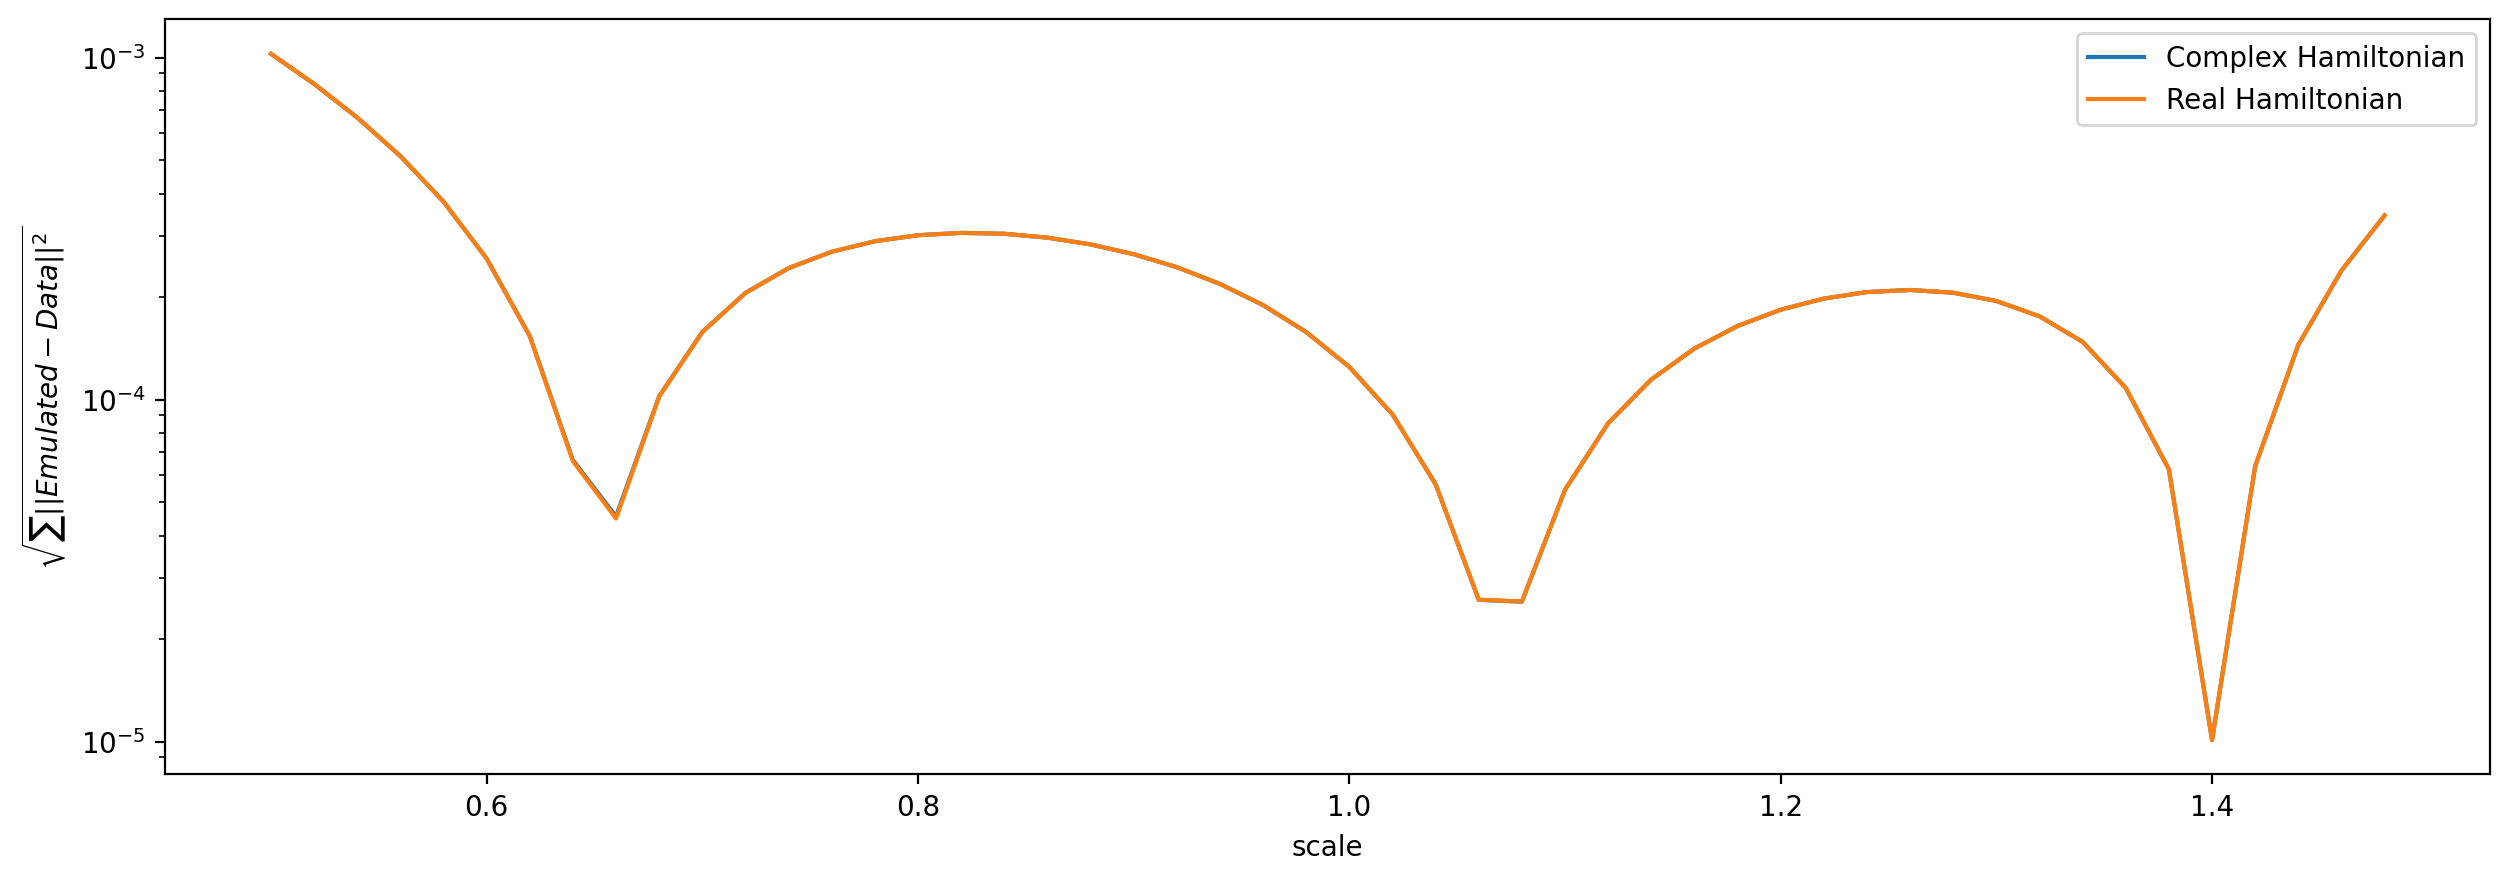

In [30]:
''' Always positive component so we can gauge '''
judgeIndex = 1367
sign = lambda p : p*np.sign(p[judgeIndex])

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')
for i,hamiltonian in enumerate(hamiltonians):
    errors = []
    for j in range(len(data[0])):
        prediction = hamiltonian.predict_real(emulator.axis[j])
        prediction = sign(prediction)
        errors.append(np.linalg.norm(data[:,j]-prediction))
    ax.semilogy(emulator.axis,errors,label=labels[i])
plt.xlabel("scale")
plt.ylabel(r'$\sqrt{\sum ||Emulated - Data||^2 }$')
plt.legend()
plt.show()

In [19]:
''' Show the optimized model(s) '''
for i,hamiltonian in enumerate(hamiltonians):
    print(labels[i])
    for j,h in enumerate(hamiltonian.hs):
        print("H"+str(j),"=\n",h)
    print()

Complex Hamiltonian
H0 =
 [[-4.45645443+0.00000000e+00j  1.89424777+6.90773188e-08j
   0.27727632+8.99157694e-06j]
 [ 1.89424777-6.90773188e-08j  2.6804438 +0.00000000e+00j
  -0.53568593+3.13240104e-05j]
 [ 0.27727632-8.99157694e-06j -0.53568593-3.13240104e-05j
   1.07807108+0.00000000e+00j]]
H1 =
 [[-0.41781612+0.00000000e+00j -1.63887474+1.98954319e-08j
  -0.26031044-7.80543989e-06j]
 [-1.63887474-1.98954319e-08j -0.22216323+0.00000000e+00j
   1.7241334 +2.47667022e-06j]
 [-0.26031044+7.80543989e-06j  1.7241334 -2.47667022e-06j
  -0.2216149 +0.00000000e+00j]]

Real Hamiltonian
H0 =
 [[-6.78643189  3.07811068  0.71062415]
 [ 3.07811068  4.52072063  0.12425827]
 [ 0.71062415  0.12425827  2.32008921]]
H1 =
 [[-0.49720679 -2.66686616 -0.64796898]
 [-2.66686616  0.13109644  2.8178831 ]
 [-0.64796898  2.8178831  -0.10907968]]



In [20]:
%%timeit
hamiltonians[0].predict_real(0.4)

297 µs ± 47.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
